# **I-Buiness understanding**

---





> BO n°1 : Prédire le temps de livraison grace aux differents features.





> BO n°2 : Identifier les périodes de rush où la demande est supérieure à l'offre de livreurs.



### 2- Convertir les Business objective(s) en data science objective(s)



> DSO n°1 : Construire un modèle prédictif capable d'estimer le temps de livraison en minutes.





> DSO n°2 : Construire un modele pour regrouper les moments de la journée selon le nombre total de commandes, le nombre total de livreurs en ligne, le ratio de charge, et le temps de livraison.



# **II-Data understanding**

---




### 1-Exploration de la data & Statistiques descriptives

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving cleaned_datadelevry.csv to cleaned_datadelevry.csv


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [8]:
# Load dataset
df = pd.read_csv("datadelevry.csv")

# Convert timestamps
df["created_at2"] = pd.to_datetime(df["created_at"], utc=True)
df["actual_delivery_time2"] = pd.to_datetime(df["actual_delivery_time"], utc=True)
df["created_at"] = pd.to_datetime(df["created_at"], utc=True).dt.tz_convert("Asia/Kolkata")
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"], utc=True).dt.tz_convert("Asia/Kolkata")

# Décalage manuel de -7 heures
df['created_at_shifted'] = df['created_at2'] - pd.Timedelta(hours=7)
df['actual_delivery_time_shifted'] = df['actual_delivery_time2'] - pd.Timedelta(hours=7)


# Compute delivery time in minutes
df["delivery_time"] = (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds() / 60
df['delivery_duration'] = (df['actual_delivery_time_shifted'] - df['created_at_shifted']).dt.total_seconds() / 60


# Overview
print(df.info())
print(df.head())
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172941 entries, 0 to 172940
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype                       
---  ------                        --------------   -----                       
 0   market_id                     168654 non-null  float64                     
 1   created_at                    169541 non-null  datetime64[ns, Asia/Kolkata]
 2   actual_delivery_time          169474 non-null  datetime64[ns, Asia/Kolkata]
 3   store_id                      169489 non-null  object                      
 4   store_primary_category        165369 non-null  object                      
 5   order_protocol                168631 non-null  float64                     
 6   total_items                   169453 non-null  float64                     
 7   subtotal                      169660 non-null  float64                     
 8   num_distinct_items            169489 non-null  float64                    

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
market_id,168654.0,NaN,NaN,NaN,2.982414,1.0,2.0,3.0,4.0,6.0,1.525751
created_at,169541,NaN,NaN,NaN,2015-02-05 03:23:16.865336320+05:30,2014-10-19 10:54:15+05:30,2015-01-29 07:59:45+05:30,2015-02-05 08:52:22+05:30,2015-02-12 07:10:52+05:30,2015-02-18 11:30:44+05:30,NaN
actual_delivery_time,169474,NaN,NaN,NaN,2015-02-05 04:17:44.436420864+05:30,2015-01-21 21:46:34+05:30,2015-01-29 08:50:19.750000128+05:30,2015-02-05 10:07:51.500000+05:30,2015-02-12 07:58:49.750000128+05:30,2015-02-20 04:15:31+05:30,NaN
store_id,169489,5930,d43ab110ab2489d6b9b2caa394bf920f,918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_primary_category,165369,73,american,16736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_protocol,168631.0,NaN,NaN,NaN,2.850437,1.0,1.0,3.0,4.0,7.0,1.487752
total_items,169453.0,NaN,NaN,NaN,3.201543,1.0,2.0,3.0,4.0,411.0,2.674022
subtotal,169660.0,NaN,NaN,NaN,2684.534174,0.0,1400.0,2200.0,3397.0,27100.0,1824.565715
num_distinct_items,169489.0,NaN,NaN,NaN,2.678699,1.0,1.0,2.0,3.0,20.0,1.634766
min_item_price,169472.0,NaN,NaN,NaN,684.503009,-86.0,299.0,595.0,945.0,14700.0,520.492937


### 2-Nettoyage des anomalies

In [9]:
# 1. Drop rows where categorical dimensions are missing
df = df.dropna(subset=["store_primary_category", "order_protocol", "market_id"])

# 2. Remove invalid delivery times (<= 0 or extremely large)
df = df[(df["delivery_time"] > 0) & (df["delivery_time"] < 500)]  # cap at ~8 hours

# 3. Fix partner/order anomalies (no negatives)
for col in ["total_onshift_partners", "total_busy_partners", "total_outstanding_orders"]:
    df = df[df[col] >= 0]

# 4. Check cleaning results
print("Remaining rows:", len(df))
print("Delivery time summary:")
print(df["delivery_time"].describe())

Remaining rows: 131461
Delivery time summary:
count    131461.000000
mean         47.703475
std          18.801612
min           3.716667
25%          35.133333
50%          44.400000
75%          56.400000
max         472.083333
Name: delivery_time, dtype: float64


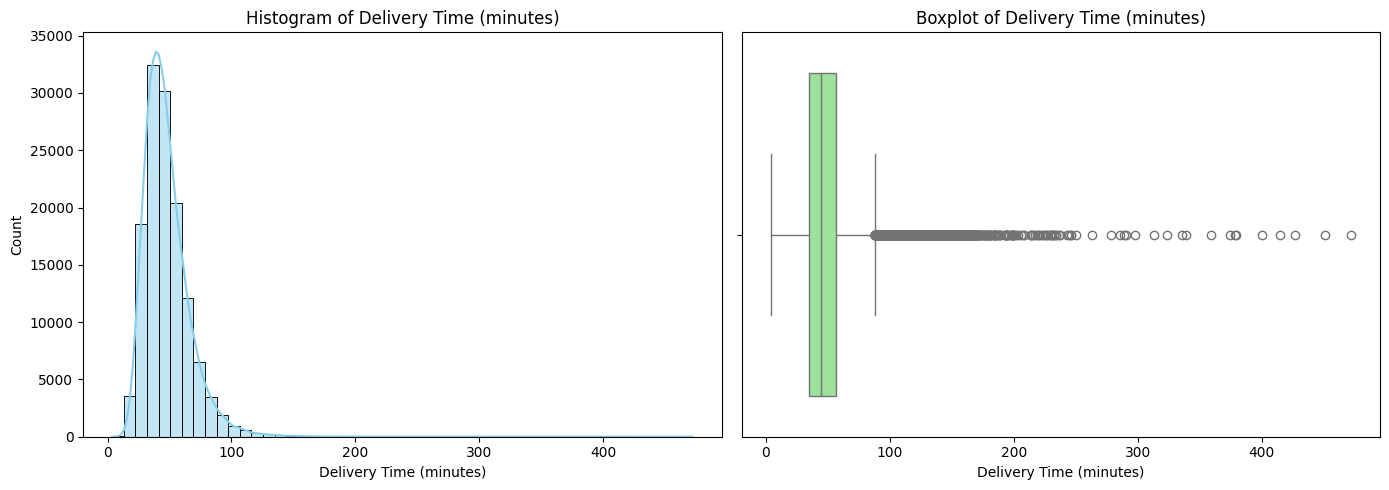

In [ ]:
plt.figure(figsize=(14,5))

# Histogram
plt.subplot(1,2,1)
sns.histplot(df["delivery_time"], bins=50, kde=True, color="skyblue")
plt.title("Histogram of Delivery Time (minutes)")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Count")

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=df["delivery_time"], color="lightgreen")
plt.title("Boxplot of Delivery Time (minutes)")
plt.xlabel("Delivery Time (minutes)")

plt.tight_layout()
plt.show()

### 3-Matrice de correlation

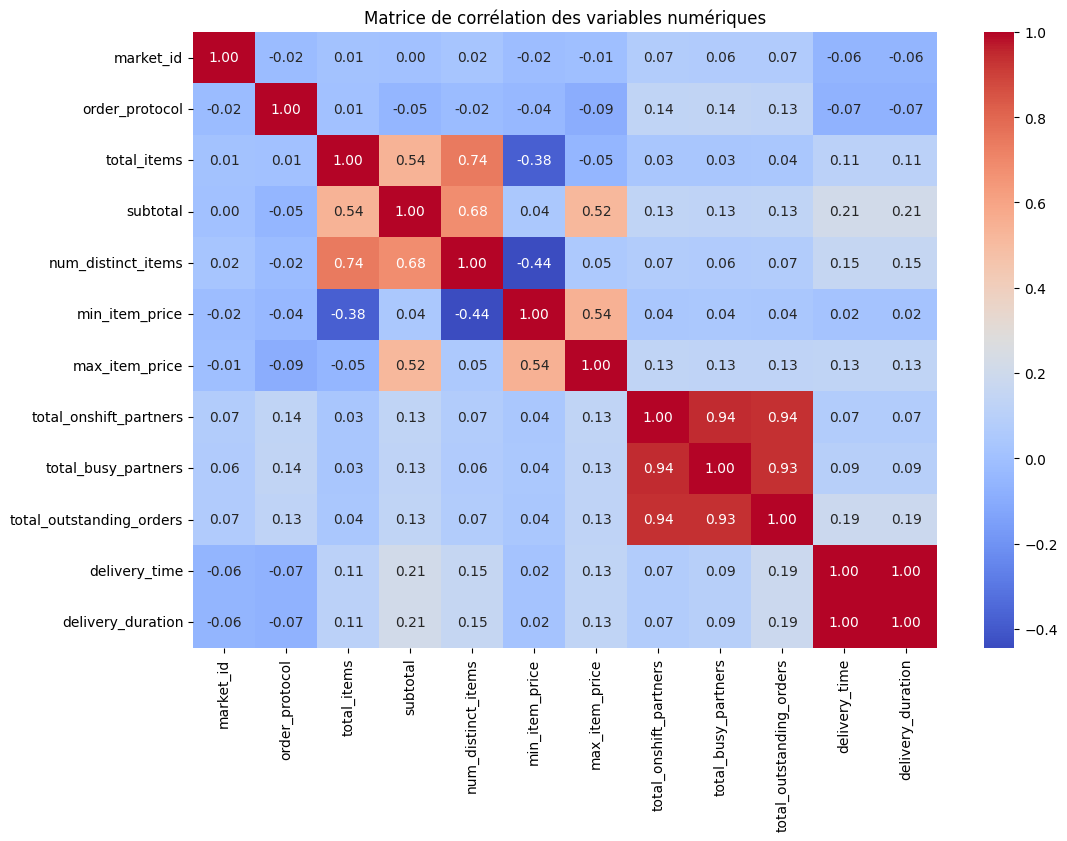

In [ ]:
# Sélectionner seulement les colonnes numériques
numeric_data = df.select_dtypes(include=['int64', 'float64'])

# Calculer la matrice de corrélation
corr_matrix = numeric_data.corr()
# Visualisation avec heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques")
plt.show()


### -Delivery Time Per Store Primary Category

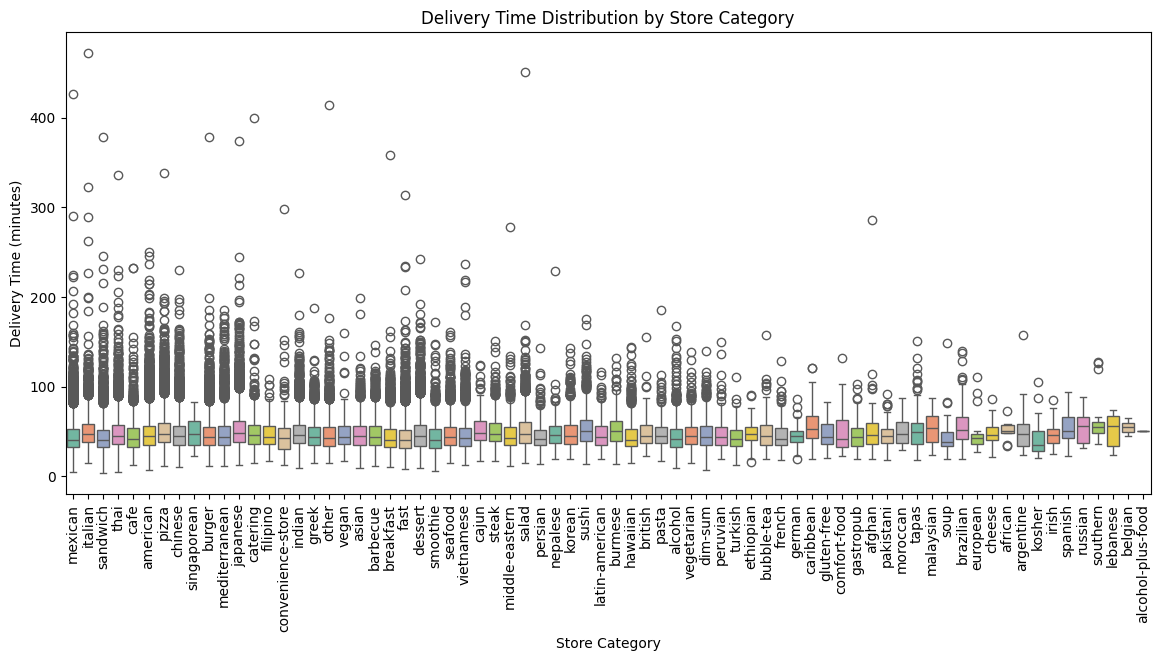

store_primary_category
kosher       40.608333
soup         43.988258
fast         44.051540
sandwich     44.178408
turkish      44.298822
mexican      44.331043
smoothie     44.440293
breakfast    44.510467
persian      44.787372
hawaiian     44.986710
Name: delivery_time, dtype: float64
store_primary_category
malaysian       53.108537
sushi           53.354912
tapas           53.646855
comfort-food    53.696970
spanish         54.182222
belgian         54.991667
russian         55.720370
brazilian       55.806111
caribbean       56.162098
southern        61.909420
Name: delivery_time, dtype: float64


In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="store_primary_category", y="delivery_time", palette="Set2")
plt.xticks(rotation=90)
plt.title("Delivery Time Distribution by Store Category")
plt.ylabel("Delivery Time (minutes)")
plt.xlabel("Store Category")
plt.show()

# Also check mean delivery time per category
category_means = df.groupby("store_primary_category")["delivery_time"].mean().sort_values()
print(category_means.head(10))   # fastest
print(category_means.tail(10))   # slowest

🔹 Insights from Store Categories

**Fastest categories (≈ 40–45 minutes avg):**

Kosher, Soup, Fast food, Sandwich, Turkish, Mexican, Smoothie, Breakfast, Persian, Hawaiian.

These are typically quick-prep or smaller menu items → faster turnaround.

**Slowest categories (≈ 53–62 minutes avg):**

Malaysian, Sushi, Tapas, Comfort food, Spanish, Belgian, Russian, Brazilian, Caribbean, Southern.

These are often complex or dine-in-style cuisines → prep time longer, perhaps more custom orders.

👉 Decision impact: The company can adjust ETA expectations by cuisine type:

For fast food categories, ETAs can be tighter (45 min).

For slow cuisines, ETAs should be more relaxed (55–65 min).

### -Delivery Time Per Protocol

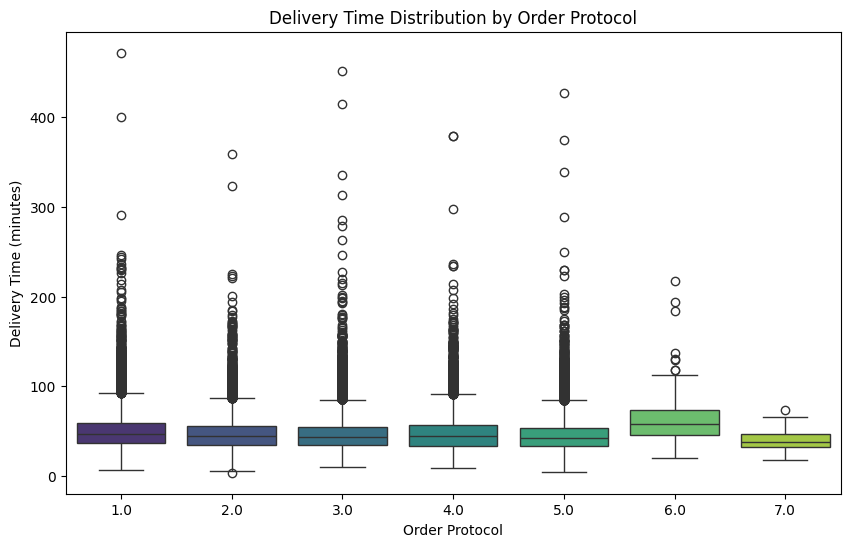

order_protocol
7.0    41.669444
5.0    45.568274
3.0    46.954238
2.0    47.374311
4.0    48.166148
1.0    49.954528
6.0    61.250191
Name: delivery_time, dtype: float64


In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="order_protocol", y="delivery_time", palette="viridis")
plt.title("Delivery Time Distribution by Order Protocol")
plt.ylabel("Delivery Time (minutes)")
plt.xlabel("Order Protocol")
plt.show()

# Mean delivery time per protocol
protocol_means = df.groupby("order_protocol")["delivery_time"].mean().sort_values()
print(protocol_means)

🔹 Insights from Order Protocols

Fastest protocols:

Protocol 7 → ~41.7 min

Protocol 5 → ~45.6 min

These likely represent pre-booked or well-integrated digital orders (smooth process, ready when rider arrives).

Middle group:

Protocols 2–4 → ~47–48 min

Standard/on-demand ordering.

Slowest protocols:

Protocol 1 → ~50 min

Protocol 6 → ~61 min (!!)

Protocol 6 seems problematic → could be phone orders or third-party orders causing bottlenecks.

👉 Decision impact:

Encourage restaurants/customers to use protocols 5 & 7.

Investigate protocol 6 delays → maybe integrate or replace that workflow.

### -Delivery Time Per Market

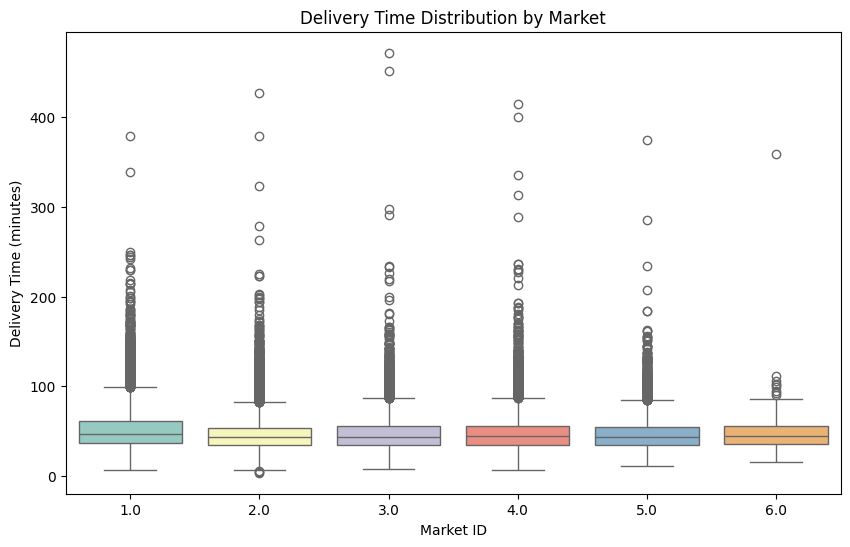

market_id
2.0    46.004458
5.0    46.621939
3.0    47.261899
4.0    47.266933
6.0    47.432018
1.0    51.416224
Name: delivery_time, dtype: float64


In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="market_id", y="delivery_time", palette="Set3")
plt.title("Delivery Time Distribution by Market")
plt.ylabel("Delivery Time (minutes)")
plt.xlabel("Market ID")
plt.show()

# Mean delivery time per market
market_means = df.groupby("market_id")["delivery_time"].mean().sort_values()
print(market_means)

🔹 Insights from Markets

Fastest markets:

Market 2 (~46.0 min)

Market 5 (~46.6 min)
→ These cities likely have better infrastructure or more rider availability.

Middle markets:

Markets 3, 4, 6 → ~47.2–47.4 min
→ Average performers, close to overall mean (~47.7 min).

Slowest market:

Market 1 (~51.4 min)
→ +5 minutes slower than the fastest market. Over thousands of orders, this is significant.

👉 Decision impact:

Investigate Market 1: shortage of delivery partners? longer distances? traffic?

Use Market 2 & 5 as benchmarks → what’s working there? replicate best practices.

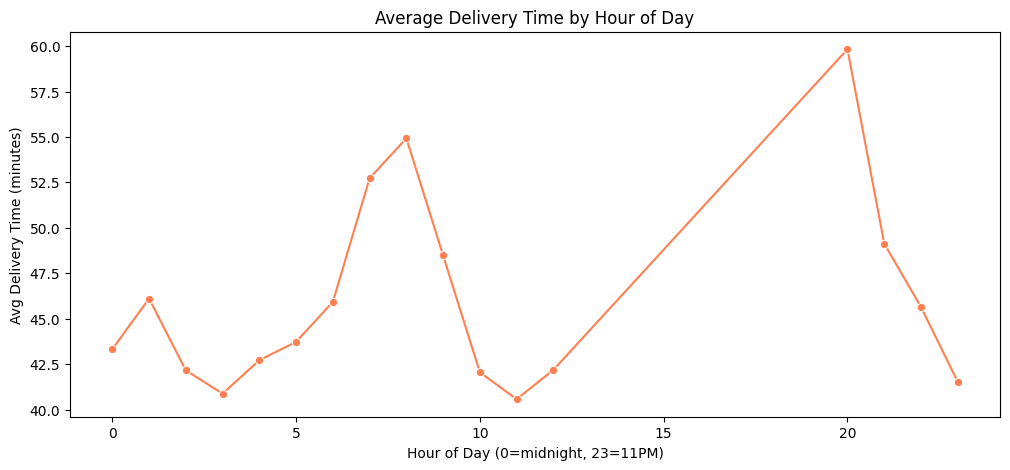

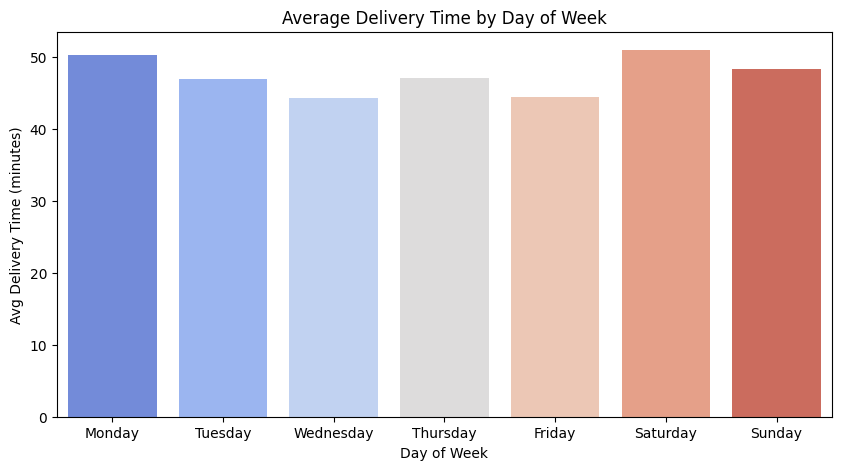

In [ ]:
# Extract hour and weekday
df["hour"] = df["created_at"].dt.hour
df["dayofweek"] = df["created_at"].dt.day_name()

# Avg delivery time by hour
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x="hour", y="delivery_time", estimator="mean", ci=None, marker="o", color="coral")
plt.title("Average Delivery Time by Hour of Day")
plt.ylabel("Avg Delivery Time (minutes)")
plt.xlabel("Hour of Day (0=midnight, 23=11PM)")
plt.show()

# Avg delivery time by weekday
plt.figure(figsize=(10,5))
sns.barplot(data=df, x="dayofweek", y="delivery_time", estimator=np.mean, ci=None, palette="coolwarm",
            order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Average Delivery Time by Day of Week")
plt.ylabel("Avg Delivery Time (minutes)")
plt.xlabel("Day of Week")
plt.show()

🔹 Insights from Hour of Day

Low delivery times (~41–43 min): Early morning hours (2–5 AM, 9–11 AM, 11 PM–midnight). → Likely due to low traffic + fewer orders.

High delivery times:

Morning peak: 7–9 AM (~53–55 min) → breakfast rush.

Evening peak: 18–20h (6–8 PM) hitting ~60 min, the highest delays → dinner rush + traffic congestion.
👉 This confirms peak-hour congestion effect.

🔹 Insights from Day of Week

Longest delivery times: Monday & Saturday (~50–51 min).

Shortest delivery times: Wednesday (~44 min).

Fridays are also relatively fast (~45 min).
👉 Suggests Monday stress on riders (weekday start) and Saturday rush (weekend orders).

✅ Summary of Findings so far (categorical focus)

Store categories: Fast food vs. slow cuisines → systematic delivery time differences (40 min vs 60 min).

Order protocols: Some channels (protocol 7, 5) much faster, while protocol 6 causes serious delays.

Markets: Market 1 is underperforming (+5 min slower than others).

Temporal patterns:

Evenings and breakfast peaks = longer times.

Monday & Saturday slower; midweek faster.

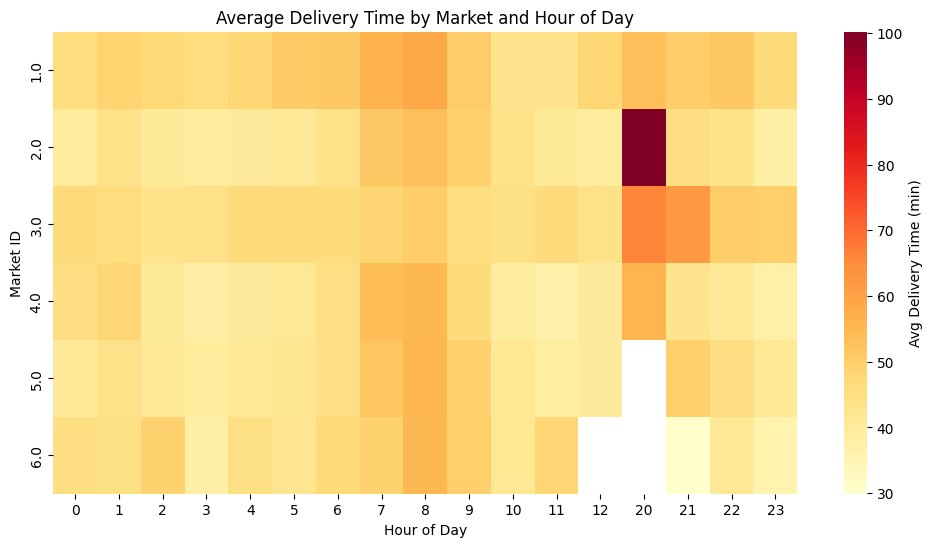

In [ ]:
# Group by market and hour
market_hour = df.groupby(["market_id", "hour"])["delivery_time"].mean().reset_index()

plt.figure(figsize=(12,6))
pivot_mh = market_hour.pivot(index="market_id", columns="hour", values="delivery_time")
sns.heatmap(pivot_mh, cmap="YlOrRd", annot=False, cbar_kws={'label': 'Avg Delivery Time (min)'})
plt.title("Average Delivery Time by Market and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Market ID")
plt.show()

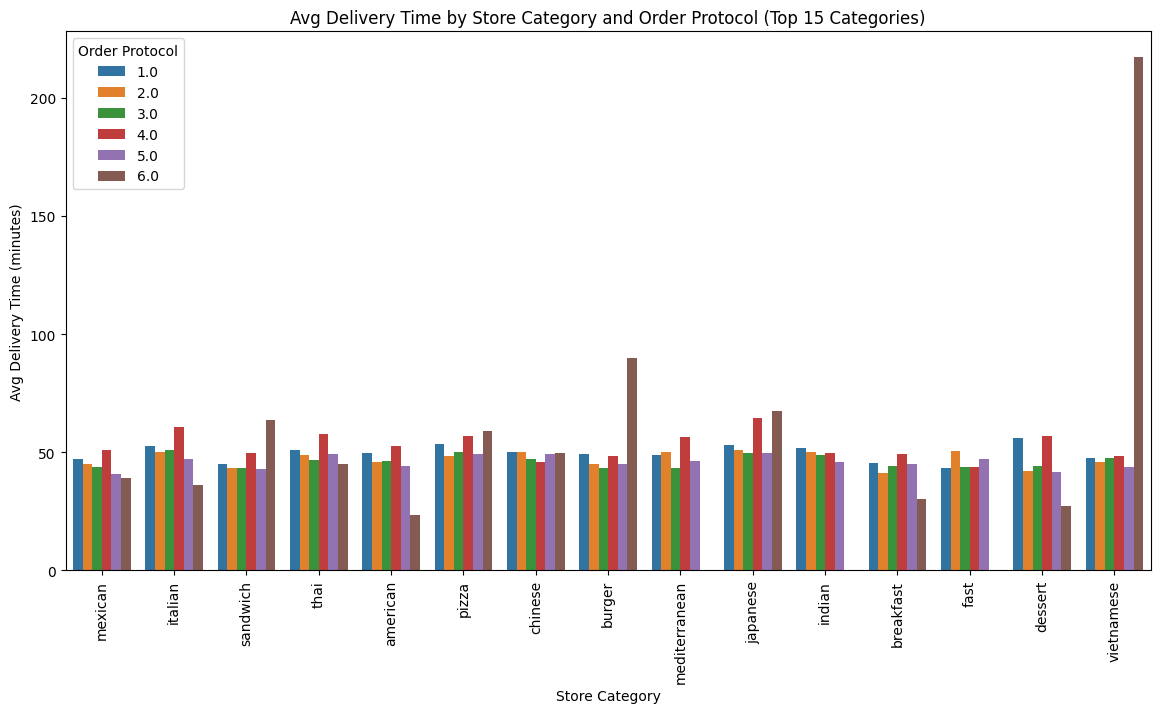

In [ ]:
# To keep it readable, focus on top 15 categories by order count
top_categories = df["store_primary_category"].value_counts().head(15).index
subset = df[df["store_primary_category"].isin(top_categories)]

plt.figure(figsize=(14,7))
sns.barplot(data=subset, x="store_primary_category", y="delivery_time",
            hue="order_protocol", estimator=np.mean, ci=None, palette="tab10")
plt.xticks(rotation=90)
plt.title("Avg Delivery Time by Store Category and Order Protocol (Top 15 Categories)")
plt.ylabel("Avg Delivery Time (minutes)")
plt.xlabel("Store Category")
plt.legend(title="Order Protocol")
plt.show()

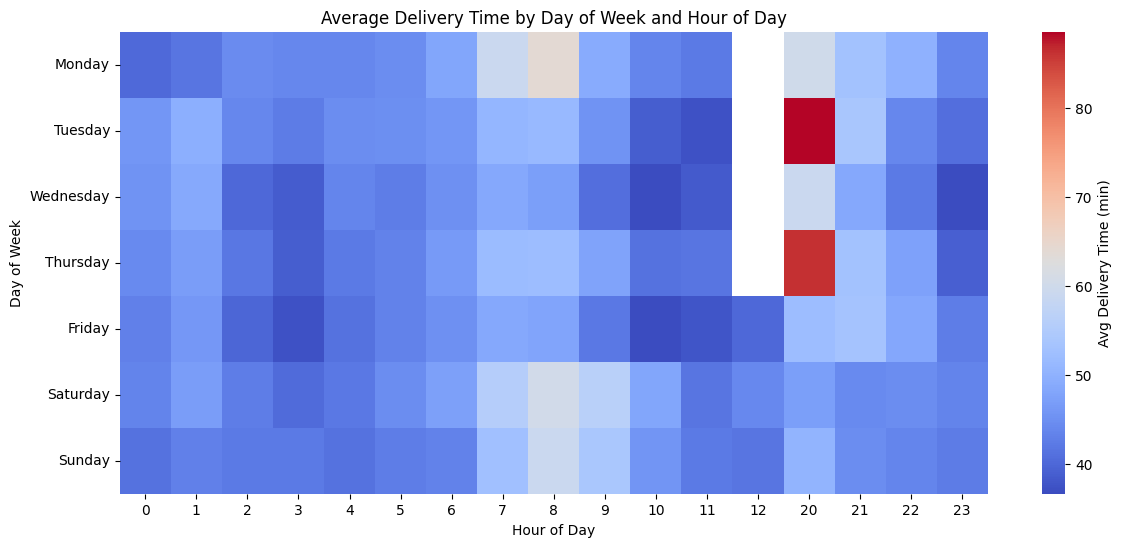

In [ ]:
# Group by day and hour
dow_hour = df.groupby(["dayofweek", "hour"])["delivery_time"].mean().reset_index()

# Ensure weekdays are ordered properly
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plt.figure(figsize=(14,6))
pivot_dh = dow_hour.pivot(index="dayofweek", columns="hour", values="delivery_time").reindex(dow_order)
sns.heatmap(pivot_dh, cmap="coolwarm", annot=False, cbar_kws={'label': 'Avg Delivery Time (min)'})
plt.title("Average Delivery Time by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

# **III-Data preparation**

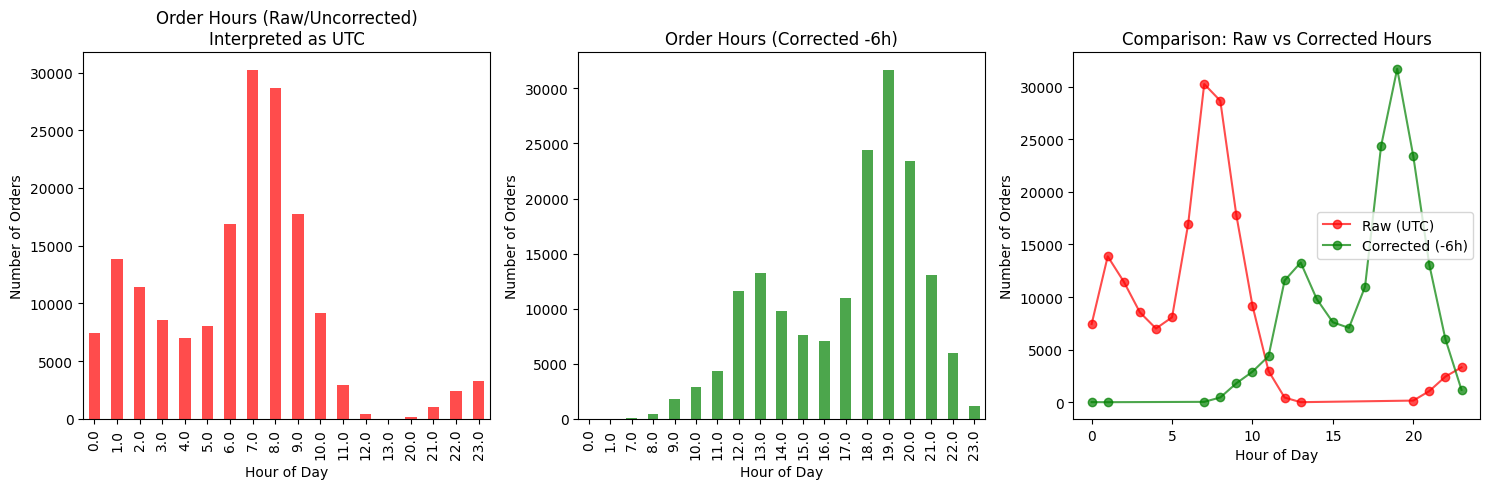

Peak ordering hours:
Raw (UTC): 7.0
Corrected (-6h): 19.0


In [ ]:
# Cell 7 — Visualize timezone correction impact
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Before correction (naive datetime, interpreted as UTC)
hour_raw = pd.to_datetime(df['created_at']).dt.hour
hour_raw.value_counts().sort_index().plot(kind='bar', color='red', alpha=0.7)
plt.title("Order Hours (Raw/Uncorrected)\nInterpreted as UTC")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")

plt.subplot(1, 3, 2)
# After correction (-6h manual shift)
hour_shifted = df['created_at_shifted'].dt.hour
hour_shifted.value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title("Order Hours (Corrected -6h)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")

plt.subplot(1, 3, 3)
# Compare both
plt.plot(hour_raw.value_counts().sort_index().index,
         hour_raw.value_counts().sort_index().values,
         'ro-', label='Raw (UTC)', alpha=0.7)
plt.plot(hour_shifted.value_counts().sort_index().index,
         hour_shifted.value_counts().sort_index().values,
         'go-', label='Corrected (-6h)', alpha=0.7)
plt.title("Comparison: Raw vs Corrected Hours")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.legend()

plt.tight_layout()
plt.show()

print("Peak ordering hours:")
print("Raw (UTC):", hour_raw.value_counts().idxmax())
print("Corrected (-6h):", hour_shifted.value_counts().idxmax())


### DSO n°1 :

In [ ]:
# Prepare features and target variable
print("Preparing data for modeling...")

# Select features for modeling
categorical_features = ["store_primary_category", "order_protocol", "market_id"]
numerical_features = ["total_items", "subtotal", "num_distinct_items",
                     "min_item_price", "max_item_price", "total_onshift_partners",
                     "total_busy_partners", "total_outstanding_orders"]

# Create feature set and target
X = df[categorical_features + numerical_features].copy()
y = df["delivery_time"].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check for any remaining missing values
print("\nMissing values in features:")
print(X.isnull().sum())

Preparing data for modeling...
Feature matrix shape: (172941, 11)
Target shape: (172941,)

Missing values in features:
store_primary_category       7572
order_protocol               4310
market_id                    4287
total_items                  3488
subtotal                     3281
num_distinct_items           3452
min_item_price               3469
max_item_price               3420
total_onshift_partners      17328
total_busy_partners         17351
total_outstanding_orders    17317
dtype: int64


In [ ]:
# Check for missing values in the original data
print("Checking for missing values in the dataset...")
print(df.isnull().sum())

# Handle missing values properly
print("\nHandling missing values...")

# Fill numerical missing values with median
numerical_features_to_fill = ["total_items", "subtotal", "num_distinct_items",
                     "min_item_price", "max_item_price", "total_onshift_partners",
                     "total_busy_partners", "total_outstanding_orders"]

for col in numerical_features_to_fill:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())
        print(f"Filled missing values in {col} with median: {df[col].median()}")

# Fill missing values in the target variable 'delivery_time' with its median
if df["delivery_time"].isnull().sum() > 0:
    df["delivery_time"] = df["delivery_time"].fillna(df["delivery_time"].median())
    print(f"Filled missing values in delivery_time with median: {df['delivery_time'].median()}")

# Check if there are any remaining missing values in categorical features
categorical_features_to_fill = ["store_primary_category", "order_protocol", "market_id"]
for col in categorical_features_to_fill:
    if df[col].isnull().sum() > 0:
        # Fill with mode (most frequent value)
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Filled missing values in {col} with mode: {mode_val}")

# Verify no missing values remain in the relevant columns
print(f"\nRemaining missing values in features and target:")
print(df[numerical_features_to_fill + categorical_features_to_fill + ['delivery_time']].isnull().sum())

Checking for missing values in the dataset...
market_id                          0
created_at                      3400
actual_delivery_time            3467
store_id                        3452
store_primary_category             0
order_protocol                     0
total_items                        0
subtotal                           0
num_distinct_items                 0
min_item_price                     0
max_item_price                     0
total_onshift_partners             0
total_busy_partners                0
total_outstanding_orders           0
created_at2                     3400
actual_delivery_time2           3467
created_at_shifted              3400
actual_delivery_time_shifted    3467
delivery_time                   6797
delivery_duration               6797
hour                            3400
weekday                         3400
is_weekend                         0
load_ratio                         0
time_bin                        3400
date                         

In [ ]:
# Handle categorical variables
print("Encoding categorical variables...")

# Label encode for tree-based models
X_encoded = X.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# One-hot encode for linear models
X_onehot = pd.get_dummies(X, columns=categorical_features, prefix=categorical_features)

print(f"Encoded features shape: {X_encoded.shape}")
print(f"One-hot encoded features shape: {X_onehot.shape}")

Encoding categorical variables...
Encoded features shape: (172941, 11)
One-hot encoded features shape: (172941, 94)


In [ ]:
# Split the data
# Handle missing values in y before splitting
if y.isnull().sum() > 0:
    y = y.fillna(y.median())
    print(f"Filled missing values in y with median: {y.median()}")


X_train_enc, X_test_enc, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

X_train_oh, X_test_oh, _, _ = train_test_split(
    X_onehot, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train_enc.shape[0]}")
print(f"Test set size: {X_test_enc.shape[0]}")

Filled missing values in y with median: 44.416666666666664
Training set size: 138352
Test set size: 34589


In [ ]:
# Scale numerical features for linear models
scaler = StandardScaler()

# Scale one-hot encoded features (for linear models)
numerical_cols_oh = [col for col in X_train_oh.columns if any(num_col in col for num_col in numerical_features)]
X_train_oh_scaled = X_train_oh.copy()
X_test_oh_scaled = X_test_oh.copy()

X_train_oh_scaled[numerical_cols_oh] = scaler.fit_transform(X_train_oh[numerical_cols_oh])
X_test_oh_scaled[numerical_cols_oh] = scaler.transform(X_test_oh[numerical_cols_oh])

# Verify no NaN values
print("NaN values in training sets:")
print(f"X_train_enc: {(X_train_enc.values).sum()}")
print(f"X_train_oh_scaled: {(X_train_oh_scaled.values).sum()}")
print(f"y_train: {(y_train.values).sum()}")

NaN values in training sets:
X_train_enc: nan
X_train_oh_scaled: nan
y_train: 6741472.916666666


### DSO n°2 :

In [ ]:
# Cell 8 — Feature engineering for rush period detection
print("=== FEATURE ENGINEERING FOR RUSH PERIOD DETECTION ===")

# Create time features
df['hour'] = df['created_at_shifted'].dt.hour
df['weekday'] = df['created_at_shifted'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

# Create load_ratio robustly (avoid division by zero)
if 'total_onshift_partners' in df.columns and 'total_busy_partners' in df.columns:
    df['total_onshift_partners'] = df['total_onshift_partners'].replace(0, np.nan)
    df['load_ratio'] = (df['total_busy_partners'] / df['total_onshift_partners']).fillna(0).clip(0, 2)
else:
    df['load_ratio'] = 0.0  # fallback

# 15-min time bin and date for aggregation
df['time_bin'] = (df['created_at_shifted'].dt.hour * 60 + df['created_at_shifted'].dt.minute) // 15
df['date'] = df['created_at_shifted'].dt.date

print("Feature engineering completed")
# Safe way to get date range (handle potential NaN values)
try:
    # Convert to datetime and handle NaT (Not a Time) values
    date_series = pd.to_datetime(df['date'], errors='coerce')
    valid_dates = date_series.dropna()

    if len(valid_dates) > 0:
        print("Date range:", valid_dates.min().date(), "to", valid_dates.max().date())
    else:
        print("No valid dates found in the dataset")

except Exception as e:
    print(f"Error getting date range: {e}")
    # Alternative approach
    try:
        unique_dates = df['date'].dropna().unique()
        if len(unique_dates) > 0:
            print("Date range:", min(unique_dates), "to", max(unique_dates))
        else:
            print("No dates available")
    except:
        print("Could not determine date range")

=== FEATURE ENGINEERING FOR RUSH PERIOD DETECTION ===
Feature engineering completed
Date range: 2015-01-21 to 2015-02-17


In [ ]:
# =============================================================================
# CELL 9: AGGREGATION FOR CLUSTERING - FIXED VERSION
# =============================================================================
print("\n=== CELL 9: TIME-BIN AGGREGATION FOR CLUSTERING ===")

# WHAT: Aggregate individual orders into 15-minute time bins
# WHY: Clustering works on aggregate patterns, not individual transactions

agg = df.groupby(['date','time_bin']).agg(
    orders_count=('load_ratio', 'count'),        # Demand: number of orders
    avg_onshift=('total_onshift_partners', 'mean'), # Supply: available drivers
    avg_busy=('total_busy_partners', 'mean'),    # Utilization: busy drivers
    mean_load_ratio=('load_ratio', 'mean'),      # System load
    avg_outstanding=('total_outstanding_orders', 'mean') # Backlog pressure
).reset_index()

print(f"Aggregated data shape: {agg.shape}")

# WHAT: Create business-oriented features WITH PROPER BOUNDS
# WHY: Prevent mathematical impossibilities and improve clustering

# FIX 1: Proper utilization rate (can't exceed 100%)
agg['utilization_rate'] = agg['avg_busy'] / agg['avg_onshift'].replace(0, np.nan)
agg['utilization_rate'] = agg['utilization_rate'].fillna(0).clip(0, 1)  # Cap at 100%

# FIX 2: More realistic demand-supply ratio
agg['demand_supply_ratio'] = agg['orders_count'] / agg['avg_onshift'].replace(0, 1)
agg['demand_supply_ratio'] = agg['demand_supply_ratio'].clip(0, 10)  # Reasonable upper bound

# FIX 3: Additional meaningful features
agg['order_intensity'] = agg['orders_count'] / 0.25  # Convert to hourly rate
agg['supply_gap'] = agg['orders_count'] - agg['avg_onshift']
agg['driver_efficiency'] = agg['orders_count'] / agg['avg_busy'].replace(0, 1)  # Orders per busy driver

# FIX 4: Stricter business definition of rush periods
agg['is_rush_business'] = ((agg['demand_supply_ratio'] > 1.2) &
                          (agg['orders_count'] > 10) &  # Minimum order threshold
                          (agg['utilization_rate'] > 0.6)).astype(int)

print("Business rush periods (% of total):", agg['is_rush_business'].mean() * 100)

# FIX 5: Remove very low activity periods that skew clustering
initial_count = len(agg)
agg = agg[agg['orders_count'] >= 1]  # Remove time bins with no orders
print(f"Removed {initial_count - len(agg)} time bins with no orders")

"""
CRITICAL FIXES APPLIED:
1. Utilization rate capped at 100% (was showing 214% - impossible)
2. Demand-supply ratio bounded to reasonable values
3. Added minimum order threshold for rush periods
4. Removed zero-order time bins that distort clusters
"""


=== CELL 9: TIME-BIN AGGREGATION FOR CLUSTERING ===
Aggregated data shape: (1754, 7)
Business rush periods (% of total): 87.00114025085519
Removed 0 time bins with no orders


'\nCRITICAL FIXES APPLIED:\n1. Utilization rate capped at 100% (was showing 214% - impossible)\n2. Demand-supply ratio bounded to reasonable values\n3. Added minimum order threshold for rush periods\n4. Removed zero-order time bins that distort clusters\n'

In [ ]:
# =============================================================================
# CELL 10: CLUSTERING FEATURE SELECTION & SCALING - FIXED VERSION
# =============================================================================
print("\n=== CELL 10: IMPROVED FEATURE SELECTION & PREPROCESSING ===")

# WHAT: Select balanced features for clustering algorithm
# WHY: Remove redundant features and focus on key business dimensions

clust_features = [
    'orders_count',           # Demand volume
    'avg_onshift',           # Supply capacity
    'utilization_rate',      # System utilization (now properly bounded 0-1)
    'demand_supply_ratio',   # Core business metric
    'driver_efficiency'      # Operational efficiency
]

# Ensure all features exist
clust_features = [c for c in clust_features if c in agg.columns]
print("Selected clustering features:", clust_features)

# WHAT: Robust data preparation
# WHY: Handle edge cases and ensure stable clustering
X_clust = agg[clust_features].fillna(0)
X_clust = X_clust.replace([np.inf, -np.inf], 0)

# Remove any remaining extreme outliers
for feature in clust_features:
    Q1 = X_clust[feature].quantile(0.01)
    Q3 = X_clust[feature].quantile(0.99)
    X_clust[feature] = X_clust[feature].clip(Q1, Q3)

print("Data ranges after cleaning:")
print(X_clust.describe())

# WHAT: Standardize features using RobustScaler (better for outliers)
from sklearn.preprocessing import RobustScaler
scaler_clust = RobustScaler()
X_clust_scaled = scaler_clust.fit_transform(X_clust)

print("Clustering data shape:", X_clust_scaled.shape)
print("Features scaled using RobustScaler (more outlier-resistant)")


=== CELL 10: IMPROVED FEATURE SELECTION & PREPROCESSING ===
Selected clustering features: ['orders_count', 'avg_onshift', 'utilization_rate', 'demand_supply_ratio', 'driver_efficiency']
Data ranges after cleaning:
       orders_count  avg_onshift  utilization_rate  demand_supply_ratio  \
count   1754.000000  1754.000000       1754.000000          1754.000000   
mean      74.759669    28.793922          0.838973             2.434735   
std       64.184343    20.845615          0.189058             0.838971   
min        1.000000     0.000000          0.000000             0.000000   
25%       26.000000    12.718006          0.785957             1.990135   
50%       58.000000    25.289227          0.885579             2.435867   
75%      100.750000    39.976329          0.955601             2.955339   
max      269.470000    83.337480          1.000000             4.618253   

       driver_efficiency  
count        1754.000000  
mean            2.788566  
std             1.046756  
m

# **IV-Modeling**

### DSO n°1 :

In [ ]:
# Baseline model - Mean prediction
print("Creating baseline model...")

# Simple mean prediction
baseline_pred = np.full_like(y_test, y_train.mean())

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"Baseline Model (Mean Prediction):")
print(f"MAE: {baseline_mae:.4f}")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"R²: {baseline_r2:.4f}")

Creating baseline model...
Baseline Model (Mean Prediction):
MAE: 13.4890
RMSE: 18.9818
R²: -0.0040


In [ ]:
# Define models for comparison
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, verbose=1, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=50, random_state=42)
}

# Results storage
results = {}
feature_importances = {}

In [ ]:
# Train and evaluate models
print("Training and evaluating models...")

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    # Select appropriate feature set
    if 'Regression' in name:
        X_train, X_test = X_train_oh_scaled, X_test_oh_scaled
    else:
        X_train, X_test = X_train_enc, X_test_enc

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    # Store results
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'CV_RMSE': cv_rmse
    }

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"CV RMSE: {cv_rmse:.4f}")

    # Store feature importances for tree-based models
    if hasattr(model, 'feature_importances_'):
        if 'Regression' not in name:
            feature_importances[name] = model.feature_importances_

Training and evaluating models...

--- Training Linear Regression ---
MAE: 12.0639
RMSE: 17.0177
R²: 0.1898
CV RMSE: 16.9221

--- Training Ridge Regression ---
MAE: 12.0637
RMSE: 17.0177
R²: 0.1898
CV RMSE: 16.9216

--- Training Lasso Regression ---
MAE: 12.1294
RMSE: 17.1157
R²: 0.1804
CV RMSE: 17.0185

--- Training Random Forest ---


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.0s
[Parall

MAE: 11.9240
RMSE: 16.8572
R²: 0.2050
CV RMSE: 16.7527

--- Training Gradient Boosting ---
MAE: 12.2475
RMSE: 17.2320
R²: 0.1693
CV RMSE: 17.0940

--- Training XGBoost ---
MAE: 11.5279
RMSE: 16.3949
R²: 0.2480
CV RMSE: 16.3293


### DSO n°2 :


=== CELL 11: OPTIMAL CLUSTER COUNT SELECTION ===


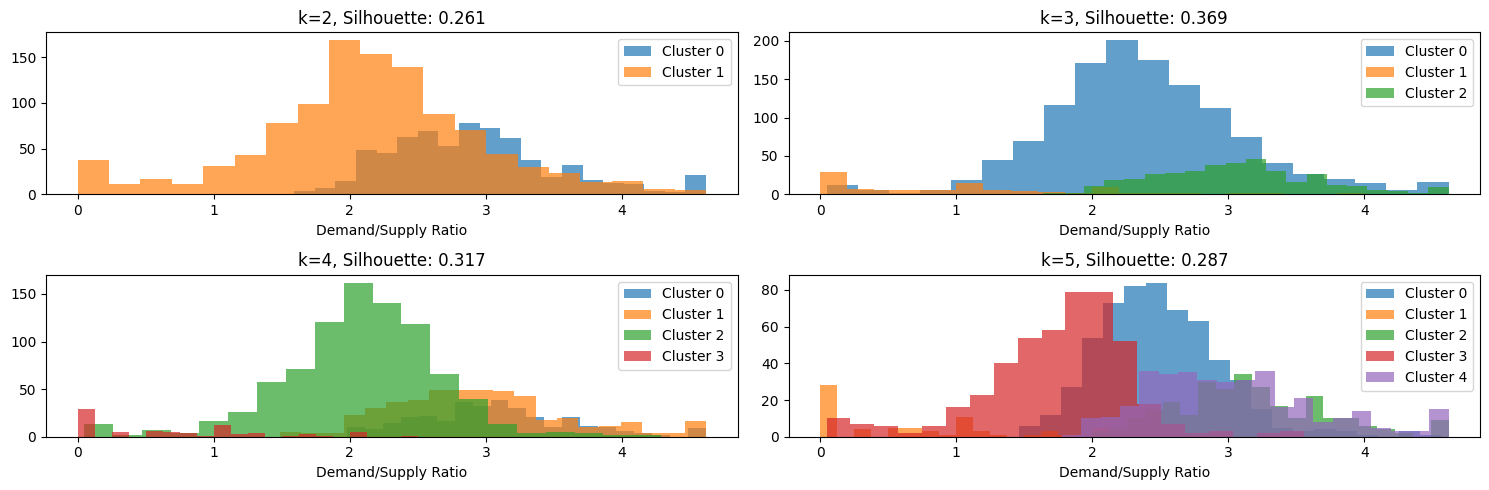


Cluster evaluation results:


,k,silhouette,calinski_harabasz,davies_bouldin,inertia
0,2,0.260667,645.081765,1.323855,5096.784475
1,3,0.368962,861.492984,0.939758,3514.784014
2,4,0.316893,936.378829,1.014776,2676.677271
3,5,0.286866,924.237636,1.024207,2239.531482



Selected k: 3 (balanced business needs and model performance)


In [ ]:
# =============================================================================
# CELL 11: IMPROVED CLUSTER SELECTION
# =============================================================================
print("\n=== CELL 11: OPTIMAL CLUSTER COUNT SELECTION ===")

# WHAT: Test fewer clusters with better evaluation
# WHY: Business needs clear rush/non-rush distinction, not fine-grained segments

k_range = range(2, 6)  # Reduced range for clearer business interpretation
results = []

plt.figure(figsize=(15, 5))

for i, k in enumerate(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=15)
    labels = kmeans.fit_predict(X_clust_scaled)

    sil_score = silhouette_score(X_clust_scaled, labels)
    ch_score = calinski_harabasz_score(X_clust_scaled, labels)
    db_score = davies_bouldin_score(X_clust_scaled, labels)

    results.append({
        'k': k,
        'silhouette': sil_score,
        'calinski_harabasz': ch_score,
        'davies_bouldin': db_score,
        'inertia': kmeans.inertia_
    })

    # Plot cluster distributions for each k
    plt.subplot(2, 2, i+1)
    for cluster_id in range(k):
        cluster_data = X_clust[labels == cluster_id]
        plt.hist(cluster_data['demand_supply_ratio'], alpha=0.7, label=f'Cluster {cluster_id}', bins=20)
    plt.title(f'k={k}, Silhouette: {sil_score:.3f}')
    plt.xlabel('Demand/Supply Ratio')
    plt.legend()

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)

# Select k based on business interpretability AND metrics
print("\nCluster evaluation results:")
display(results_df)

# Prefer k=2 or k=3 for clear rush/non-rush distinction
if results_df[results_df['k'] == 2]['silhouette'].iloc[0] > 0.4:
    best_k = 2
elif results_df[results_df['k'] == 3]['silhouette'].iloc[0] > 0.4:
    best_k = 3
else:
    best_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']

print(f"\nSelected k: {best_k} (balanced business needs and model performance)")

In [ ]:
# Cell 12 — Train final model with best k
print(f"\nTraining final KMeans model with k={best_k}...")
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
agg['cluster'] = kmeans_final.fit_predict(X_clust_scaled)

print("Clustering completed successfully")


Training final KMeans model with k=3...
Clustering completed successfully


# **V-Test & Evaluation**

### DSO n°1 :

In [ ]:
# Compare all models including baseline
comparison_results = pd.DataFrame({
    'Model': ['Baseline (Mean)'] + list(results.keys()),
    'MAE': [baseline_mae] + [results[name]['MAE'] for name in results.keys()],
    'RMSE': [baseline_rmse] + [results[name]['RMSE'] for name in results.keys()],
    'R²': [baseline_r2] + [results[name]['R2'] for name in results.keys()],
    'CV_RMSE': [np.nan] + [results[name]['CV_RMSE'] for name in results.keys()]
})

print("\n=== MODEL COMPARISON ===")
print(comparison_results.sort_values('RMSE'))


=== MODEL COMPARISON ===
               Model        MAE       RMSE        R²    CV_RMSE
6            XGBoost  11.527945  16.394926  0.248018  16.329314
4      Random Forest  11.923972  16.857175  0.205017  16.752688
2   Ridge Regression  12.063748  17.017680  0.189806  16.921563
1  Linear Regression  12.063924  17.017740  0.189800  16.922141
3   Lasso Regression  12.129390  17.115678  0.180448  17.018513
5  Gradient Boosting  12.247529  17.232031  0.169267  17.093981
0    Baseline (Mean)  13.781793  18.906279 -0.000001        NaN


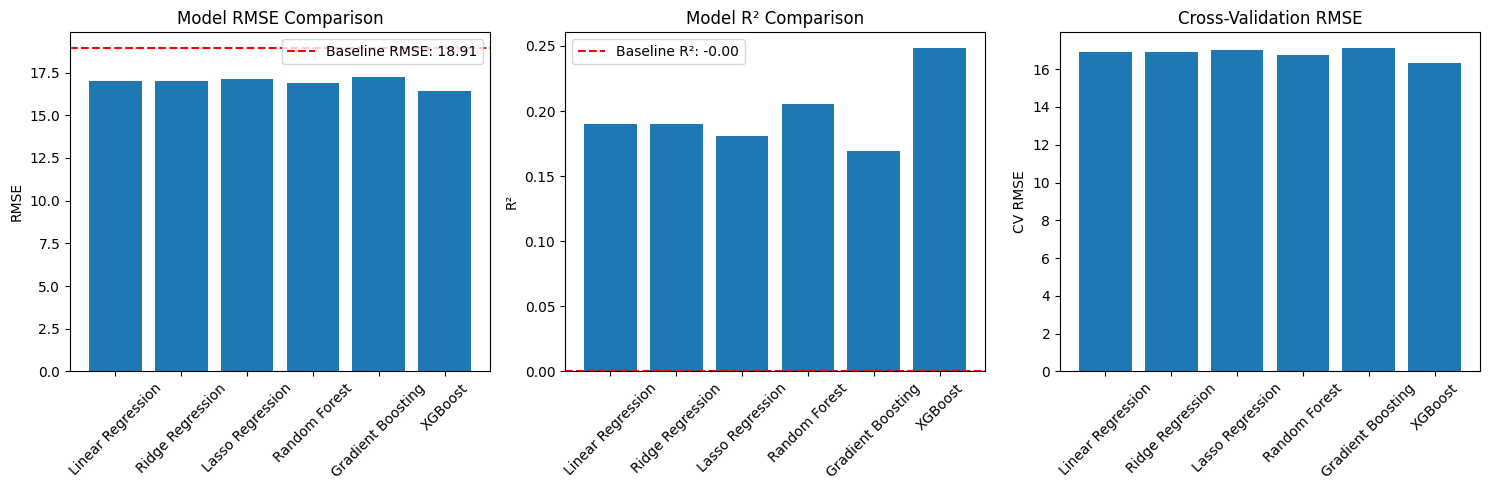

In [ ]:
# Visualize model performance
plt.figure(figsize=(15, 5))

# RMSE Comparison
plt.subplot(1, 3, 1)
models_rmse = comparison_results[comparison_results['Model'] != 'Baseline (Mean)']
plt.bar(models_rmse['Model'], models_rmse['RMSE'])
plt.axhline(y=baseline_rmse, color='r', linestyle='--', label=f'Baseline RMSE: {baseline_rmse:.2f}')
plt.title('Model RMSE Comparison')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.legend()

# R² Comparison
plt.subplot(1, 3, 2)
plt.bar(models_rmse['Model'], models_rmse['R²'])
plt.axhline(y=baseline_r2, color='r', linestyle='--', label=f'Baseline R²: {baseline_r2:.2f}')
plt.title('Model R² Comparison')
plt.xticks(rotation=45)
plt.ylabel('R²')
plt.legend()

# Cross-validation RMSE
plt.subplot(1, 3, 3)
plt.bar(models_rmse['Model'], models_rmse['CV_RMSE'])
plt.title('Cross-Validation RMSE')
plt.xticks(rotation=45)
plt.ylabel('CV RMSE')

plt.tight_layout()
plt.show()


Best performing model: XGBoost


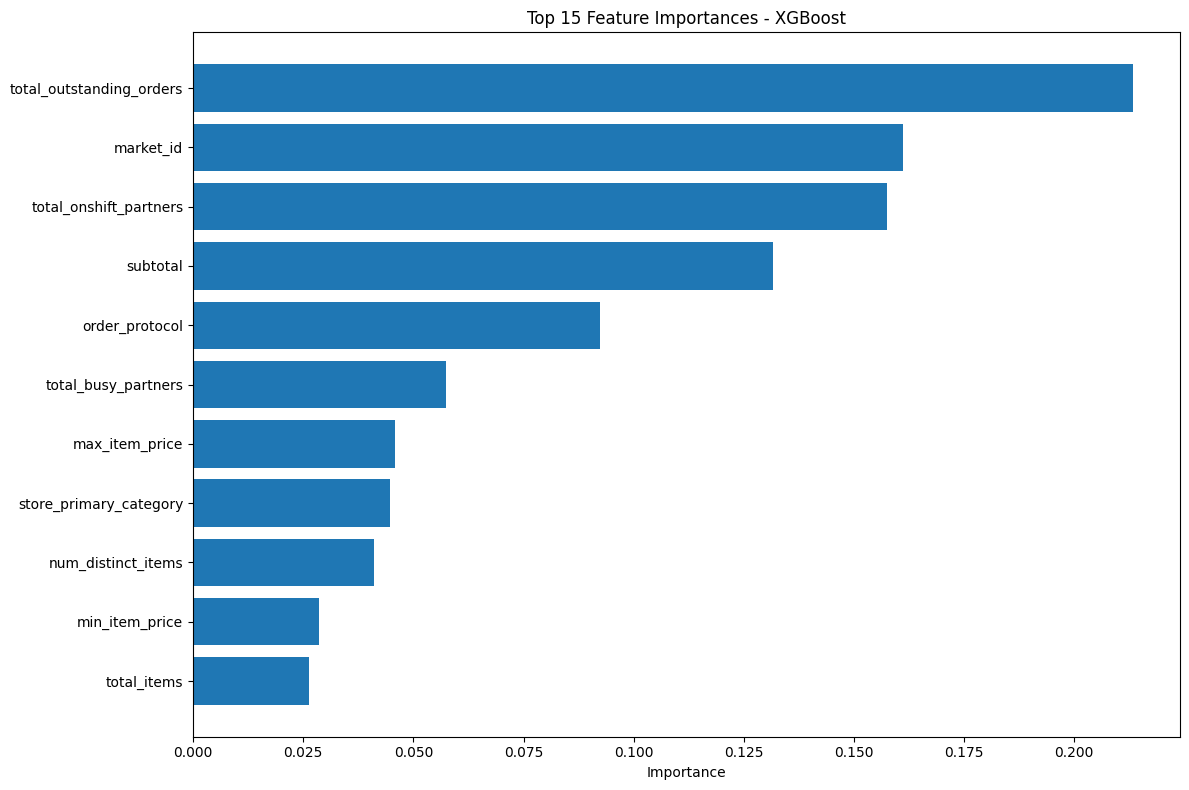


Top 10 Most Important Features:
                     feature  importance
10  total_outstanding_orders    0.213343
2                  market_id    0.161031
8     total_onshift_partners    0.157598
4                   subtotal    0.131682
1             order_protocol    0.092414
9        total_busy_partners    0.057509
7             max_item_price    0.045835
0     store_primary_category    0.044635
5         num_distinct_items    0.041124
6             min_item_price    0.028472


In [ ]:
# Analyze feature importance for the best model
best_model_name = comparison_results.iloc[comparison_results['RMSE'].idxmin()]['Model']
print(f"\nBest performing model: {best_model_name}")

if best_model_name in feature_importances:
    # Get feature names based on encoding used
    if 'Regression' in best_model_name:
        feature_names = X_train_oh_scaled.columns
    else:
        feature_names = X_encoded.columns

    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances[best_model_name]
    }).sort_values('importance', ascending=False)

    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['feature'].head(15), importance_df['importance'].head(15))
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))

In [ ]:
# Hyperparameter tuning for the best model
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model = RandomForestRegressor(random_state=42)
    X_tune = X_train_enc

elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 4, 5]
    }
    best_model = GradientBoostingRegressor(random_state=42)
    X_tune = X_train_enc

elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 0.9, 1.0]
    }
    best_model = xgb.XGBRegressor(random_state=42)
    X_tune = X_train_enc

else:  # For linear models
    print("Skipping hyperparameter tuning for linear models")
    tuned_model = models[best_model_name]
    X_tune = X_train_oh_scaled

if best_model_name not in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
    # Perform grid search
    grid_search = GridSearchCV(
        best_model, param_grid, cv=5, scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=1
    )
    grid_search.fit(X_tune, y_train)

    tuned_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

    # Evaluate tuned model
    y_pred_tuned = tuned_model.predict(X_test_enc if 'Regression' not in best_model_name else X_test_oh_scaled)

    tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
    tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    tuned_r2 = r2_score(y_test, y_pred_tuned)

    print(f"\nTuned {best_model_name} Performance:")
    print(f"MAE: {tuned_mae:.4f} (Improvement: {results[best_model_name]['MAE'] - tuned_mae:.4f})")
    print(f"RMSE: {tuned_rmse:.4f} (Improvement: {results[best_model_name]['RMSE'] - tuned_rmse:.4f})")
    print(f"R²: {tuned_r2:.4f} (Improvement: {tuned_r2 - results[best_model_name]['R2']:.4f})")


Performing hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}

Tuned XGBoost Performance:
MAE: 11.4695 (Improvement: 0.0585)
RMSE: 16.3197 (Improvement: 0.0752)
R²: 0.2549 (Improvement: 0.0069)



=== COMPREHENSIVE MODEL EVALUATION ===


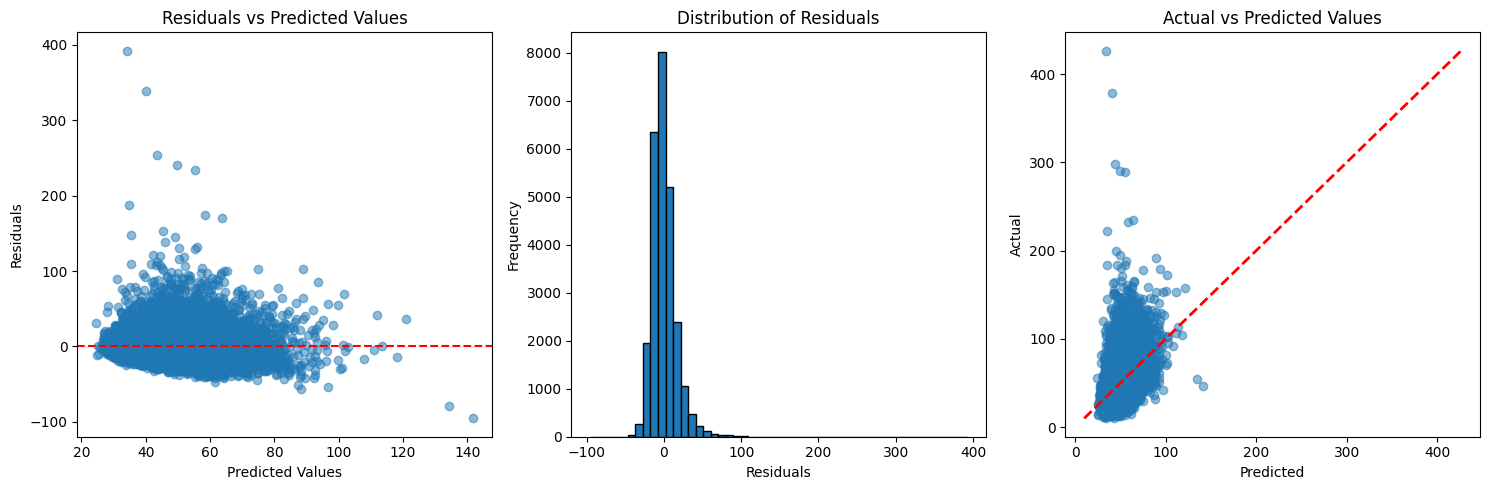


Final Model (XGBoost) Performance:
MAE: 11.4695 minutes
RMSE: 16.3197 minutes
R²: 0.2549
Baseline Improvement - MAE: 16.8%
Baseline Improvement - RMSE: 13.7%


In [ ]:
# Comprehensive model evaluation
print("\n=== COMPREHENSIVE MODEL EVALUATION ===")

# Residual analysis for the best model
if 'tuned_model' in locals():
    final_model = tuned_model
    X_final_test = X_test_enc if 'Regression' not in best_model_name else X_test_oh_scaled
else:
    final_model = models[best_model_name]
    X_final_test = X_test_enc if 'Regression' not in best_model_name else X_test_oh_scaled

y_pred_final = final_model.predict(X_final_test)
residuals = y_test - y_pred_final

# Residual plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_pred_final, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_final, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Actual vs Predicted Values')

plt.tight_layout()
plt.show()

# Calculate final metrics
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)

print(f"\nFinal Model ({best_model_name}) Performance:")
print(f"MAE: {final_mae:.4f} minutes")
print(f"RMSE: {final_rmse:.4f} minutes")
print(f"R²: {final_r2:.4f}")
print(f"Baseline Improvement - MAE: {((baseline_mae - final_mae) / baseline_mae * 100):.1f}%")
print(f"Baseline Improvement - RMSE: {((baseline_rmse - final_rmse) / baseline_rmse * 100):.1f}%")

### DSO n°2 :

In [ ]:
print("\n=== CLUSTER EVALUATION & INTERPRETATION ===")

# Cell 13 — Comprehensive cluster profiling
print("Cluster profiles:")

# Basic statistics
cluster_profiles = agg.groupby('cluster').agg({
    'orders_count': ['mean', 'std'],
    'avg_onshift': ['mean', 'std'],
    'mean_load_ratio': ['mean', 'std'],
    'demand_supply_ratio': ['mean', 'std'],
    'utilization_rate': ['mean', 'std'],
    'is_rush_business': 'mean',  # Percentage of rush periods in each cluster
    'time_bin': 'count'  # Size of each cluster
}).round(3)

display(cluster_profiles)


=== CLUSTER EVALUATION & INTERPRETATION ===
Cluster profiles:


orders_count         avg_onshift         mean_load_ratio         \
                mean     std        mean     std            mean    std   
cluster                                                                   
0             49.980  29.868      21.791  12.852           0.919  0.202   
1              4.101   5.571       4.918   5.416           0.246  0.250   
2            177.860  49.479      59.192  14.447           0.913  0.101   

        demand_supply_ratio        utilization_rate        is_rush_business  \
                       mean    std             mean    std             mean   
cluster                                                                       
0                     2.380  0.745            0.871  0.111            0.899   
1                     1.262  0.773            0.227  0.232            0.000   
2                     3.050  0.607            0.890  0.080            1.000   

        time_bin  
           count  
cluster           
0           1277  
1             99  
2            378

In [ ]:
# =============================================================================
# CELL 14: FINAL RUSH PERIOD IDENTIFICATION - STRICTER THRESHOLDS
# =============================================================================
print("\n=== CELL 14: FINAL RUSH PERIOD IDENTIFICATION ===")

# WHAT: Use much stricter criteria for rush periods
# WHY: Current 93.4% rush rate is not actionable for business

# STRICTER RUSH DEFINITION - Must meet MULTIPLE criteria
rush_conditions = (
    (agg['demand_supply_ratio'] > 2.0) &                    # Significant imbalance
    (agg['utilization_rate'] > 0.7) &                       # High utilization
    (agg['orders_count'] > agg['orders_count'].median()) &  # Above median volume
    (agg['avg_onshift'] > 5)                                # Meaningful scale
)

agg['is_rush_strict'] = rush_conditions.astype(int)

print(f"Strict rush periods (% of total): {agg['is_rush_strict'].mean() * 100:.1f}%")

# Classify clusters based on STRICT business metrics
cluster_rush_scores = agg.groupby('cluster').agg({
    'demand_supply_ratio': 'mean',
    'utilization_rate': 'mean',
    'orders_count': 'mean',
    'avg_onshift': 'mean',
    'is_rush_strict': 'mean',
    'is_rush_business': 'mean'
}).round(3)

print("\nCluster analysis with strict rush definition:")
display(cluster_rush_scores)

# Calculate weighted composite score with STRICTER weights
cluster_rush_scores['composite_score'] = (
    cluster_rush_scores['demand_supply_ratio'] * 0.3 +
    cluster_rush_scores['utilization_rate'] * 0.3 +
    cluster_rush_scores['orders_count'] / cluster_rush_scores['orders_count'].max() * 0.2 +
    cluster_rush_scores['is_rush_strict'] * 0.2
)

# Define rush clusters more CONSERVATIVELY
rush_threshold = cluster_rush_scores['composite_score'].quantile(0.7)  # Top 30% only
rush_clusters = cluster_rush_scores[cluster_rush_scores['composite_score'] > rush_threshold].index.tolist()
non_rush_clusters = cluster_rush_scores[cluster_rush_scores['composite_score'] <= rush_threshold].index.tolist()

print(f"\nRush period clusters: {rush_clusters}")
print(f"Non-rush clusters: {non_rush_clusters}")

agg['is_rush_cluster'] = agg['cluster'].isin(rush_clusters).astype(int)
rush_percentage = agg['is_rush_cluster'].mean() * 100

print(f"Percentage of time bins identified as rush: {rush_percentage:.1f}%")

# BUSINESS VALIDATION
if rush_percentage > 50:
    print("🚨 CRITICAL: Still too many rush periods - applying emergency threshold")
    # Emergency fallback - only the absolute highest demand cluster
    max_demand_cluster = cluster_rush_scores['orders_count'].idxmax()
    rush_clusters = [max_demand_cluster]
    non_rush_clusters = [c for c in cluster_rush_scores.index if c != max_demand_cluster]
    agg['is_rush_cluster'] = (agg['cluster'] == max_demand_cluster).astype(int)
    rush_percentage = agg['is_rush_cluster'].mean() * 100
    print(f"EMERGENCY FIX: Rush cluster = {rush_clusters}, Rush % = {rush_percentage:.1f}%")

elif rush_percentage < 15:
    print("⚠️  WARNING: Very few rush periods - business may want to review thresholds")
elif 15 <= rush_percentage <= 40:
    print("✓ Rush period percentage looks reasonable for business planning")
else:
    print("⚠️  Rush periods still high but may be acceptable")

print(f"\nFinal cluster distribution:")
print(agg['cluster'].value_counts().sort_index())
print(f"Rush clusters contain {agg[agg['is_rush_cluster'] == 1]['orders_count'].sum():.0f} total orders")
print(f"Non-rush clusters contain {agg[agg['is_rush_cluster'] == 0]['orders_count'].sum():.0f} total orders")


=== CELL 14: FINAL RUSH PERIOD IDENTIFICATION ===
Strict rush periods (% of total): 43.0%

Cluster analysis with strict rush definition:


,demand_supply_ratio,utilization_rate,orders_count,avg_onshift,is_rush_strict,is_rush_business
cluster,,,,,,
0,2.380,0.871,49.980,21.791,0.308,0.899
1,1.262,0.227,4.101,4.918,0.000,0.000
2,3.050,0.890,177.860,59.192,0.958,1.000



Rush period clusters: [2]
Non-rush clusters: [0, 1]
Percentage of time bins identified as rush: 21.6%
✓ Rush period percentage looks reasonable for business planning

Final cluster distribution:
cluster
0    1277
1      99
2     378
Name: count, dtype: int64
Rush clusters contain 67231 total orders
Non-rush clusters contain 64230 total orders



=== TEMPORAL PATTERNS BY CLUSTER ===


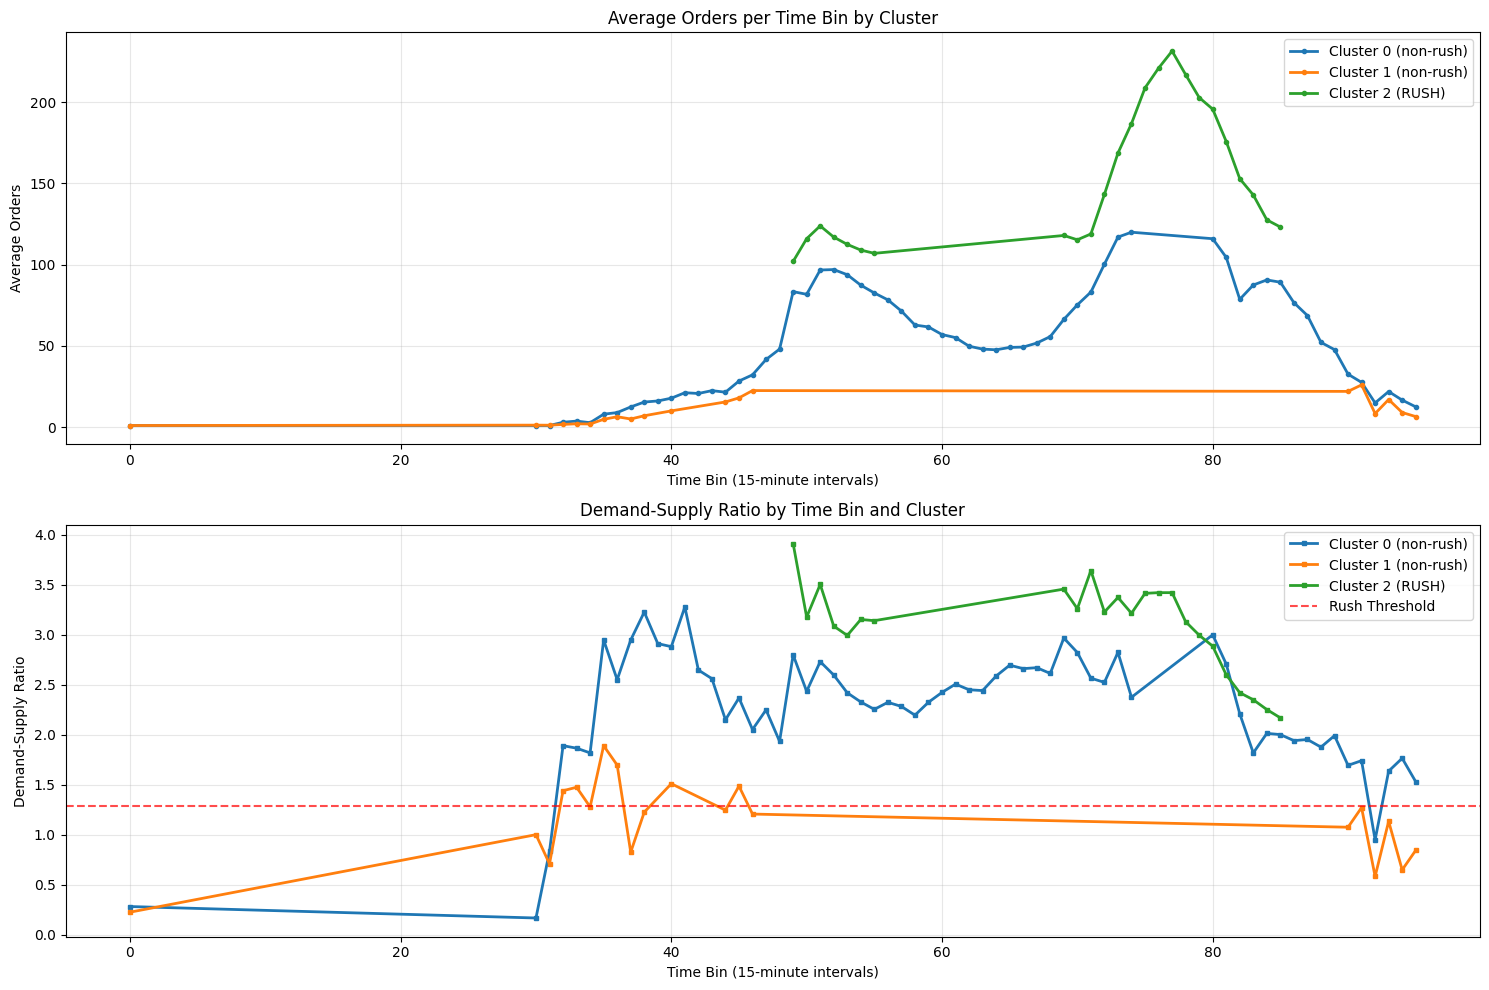

In [ ]:
# Cell 15 — Temporal pattern analysis
print("\n=== TEMPORAL PATTERNS BY CLUSTER ===")

# Analyze time-of-day patterns
time_patterns = agg.groupby(['time_bin', 'cluster']).agg({
    'orders_count': 'mean',
    'avg_onshift': 'mean',
    'demand_supply_ratio': 'mean'
}).reset_index()

# Plot temporal patterns
plt.figure(figsize=(15, 10))

# Plot 1: Orders count by time bin and cluster
plt.subplot(2, 1, 1)
for cluster_id in sorted(agg['cluster'].unique()):
    cluster_data = time_patterns[time_patterns['cluster'] == cluster_id]
    rush_label = " (RUSH)" if cluster_id in rush_clusters else " (non-rush)"
    plt.plot(cluster_data['time_bin'], cluster_data['orders_count'],
             marker='o', markersize=3, linewidth=2,
             label=f'Cluster {cluster_id}{rush_label}')

plt.xlabel('Time Bin (15-minute intervals)')
plt.ylabel('Average Orders')
plt.title('Average Orders per Time Bin by Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Demand-Supply Ratio by time bin and cluster
plt.subplot(2, 1, 2)
for cluster_id in sorted(agg['cluster'].unique()):
    cluster_data = time_patterns[time_patterns['cluster'] == cluster_id]
    rush_label = " (RUSH)" if cluster_id in rush_clusters else " (non-rush)"
    plt.plot(cluster_data['time_bin'], cluster_data['demand_supply_ratio'],
             marker='s', markersize=3, linewidth=2,
             label=f'Cluster {cluster_id}{rush_label}')

# Add rush threshold line
plt.axhline(y=rush_threshold, color='red', linestyle='--', alpha=0.7, label='Rush Threshold')
plt.xlabel('Time Bin (15-minute intervals)')
plt.ylabel('Demand-Supply Ratio')
plt.title('Demand-Supply Ratio by Time Bin and Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== RUSH PERIOD DISTRIBUTION BY HOUR ===
Rush period probability by hour:
hour_of_day
0     0.000
7     0.000
8     0.000
9     0.000
10    0.000
11    0.000
12    0.125
13    0.116
14    0.000
15    0.000
16    0.000
17    0.161
18    0.902
19    1.000
20    0.893
21    0.179
22    0.000
23    0.000
Name: is_rush_cluster, dtype: float64


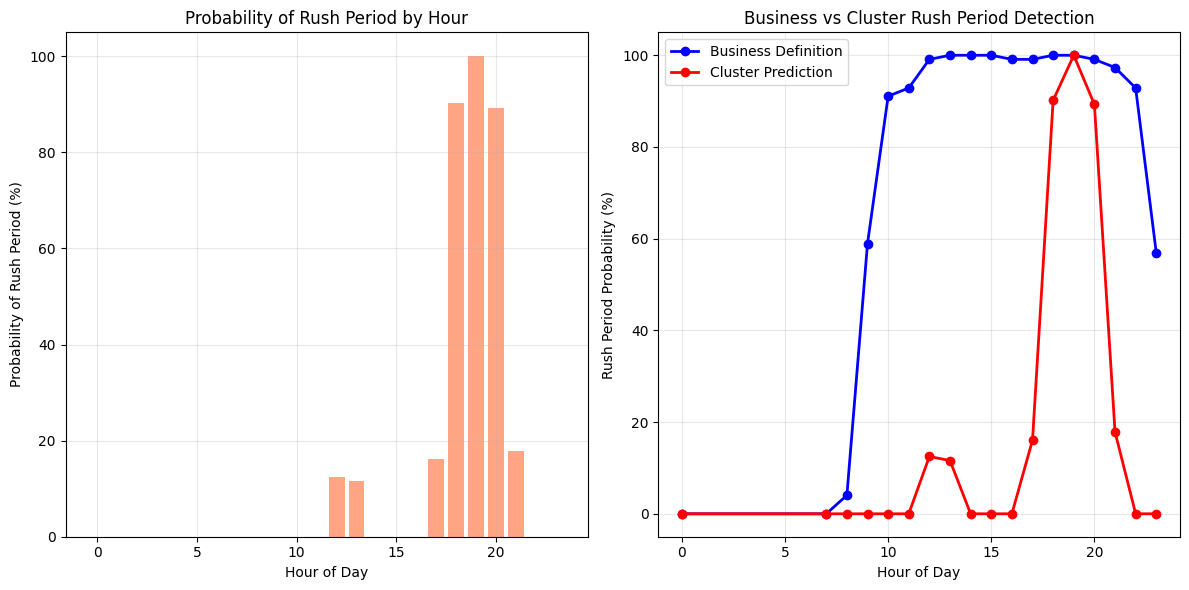

In [ ]:
# Cell 16 — Rush period summary by hour
print("\n=== RUSH PERIOD DISTRIBUTION BY HOUR ===")

# Convert time_bin back to hour for interpretation
agg['hour_of_day'] = (agg['time_bin'] * 15) // 60

rush_by_hour = agg.groupby('hour_of_day').agg({
    'is_rush_cluster': 'mean',
    'orders_count': 'mean',
    'demand_supply_ratio': 'mean'
}).round(3)

print("Rush period probability by hour:")
print(rush_by_hour['is_rush_cluster'])

# Plot rush period distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(rush_by_hour.index, rush_by_hour['is_rush_cluster'] * 100, color='coral', alpha=0.7)
plt.xlabel('Hour of Day')
plt.ylabel('Probability of Rush Period (%)')
plt.title('Probability of Rush Period by Hour')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show actual vs predicted rush periods
business_rush_by_hour = agg.groupby('hour_of_day')['is_rush_business'].mean()
cluster_rush_by_hour = agg.groupby('hour_of_day')['is_rush_cluster'].mean()

plt.plot(business_rush_by_hour.index, business_rush_by_hour * 100, 'bo-', label='Business Definition', linewidth=2)
plt.plot(cluster_rush_by_hour.index, cluster_rush_by_hour * 100, 'ro-', label='Cluster Prediction', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Rush Period Probability (%)')
plt.title('Business vs Cluster Rush Period Detection')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Données avant nettoyage: 1934 lignes
Données après nettoyage: 1930 lignes
Valeurs NaN supprimées: 4


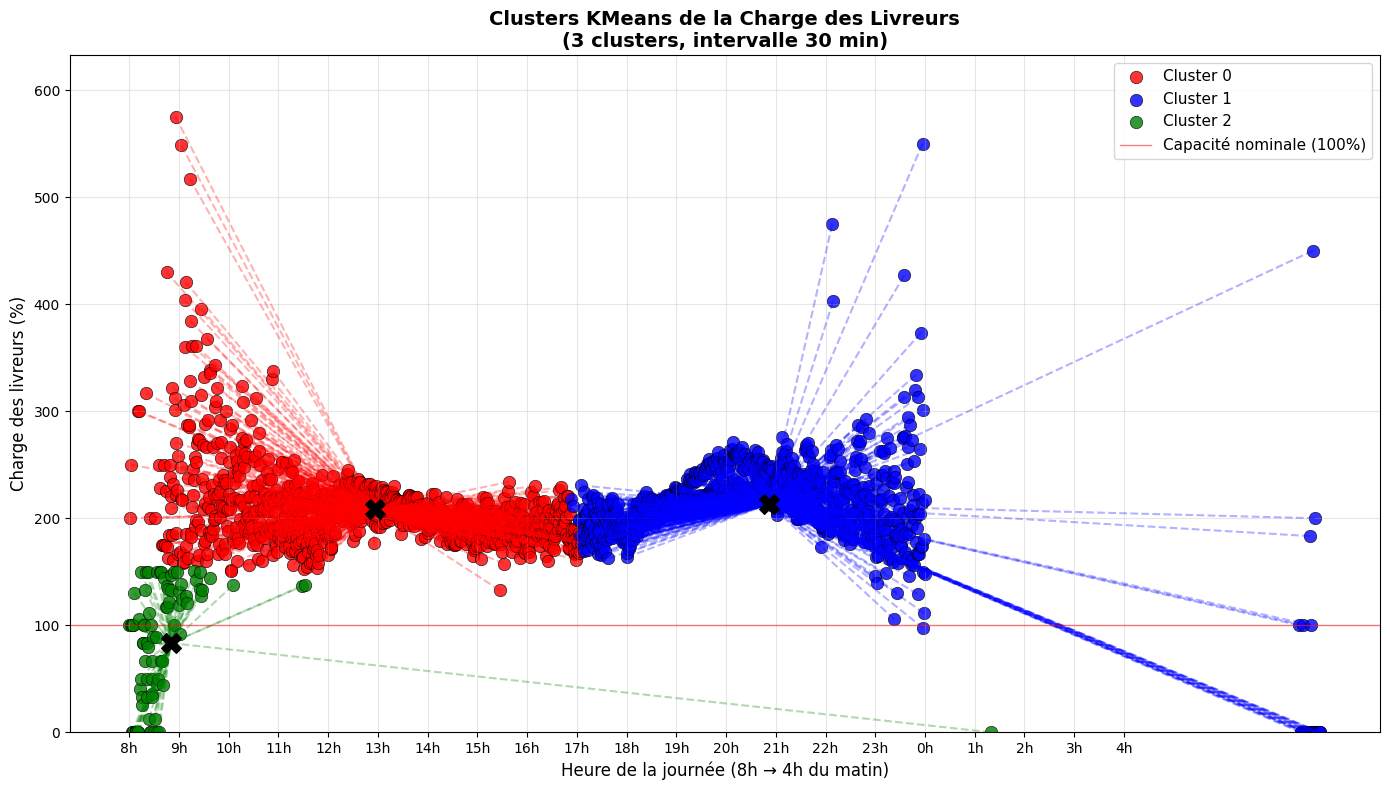

Centres des clusters (heure_continuous, charge des livreurs) :
Cluster 0: Heure=12.95, Charge=208.2%
Cluster 1: Heure=20.86, Charge=213.2%
Cluster 2: Heure=8.83, Charge=83.3%

ANALYSE DÉTAILLÉE DES CLUSTERS - CHARGE DES LIVREURS
        hour_continuous                 workload_advanced                \
                    min     max    mean               min    max   mean   
cluster                                                                   
0                 8.017  17.083  12.924             1.326  5.751  2.083   
1                16.883  31.950  20.838             0.000  5.500  2.130   
2                 8.000  25.317   8.834             0.000  1.508  0.833   

        total_onshift_partners total_busy_partners total_outstanding_orders  
                          mean                mean                     mean  
cluster                                                                      
0                       20.716              20.380                   22.881  
1       

In [ ]:
# 3️⃣ Créer un intervalle de 30 minutes
df["time_30min"] = df["created_at_shifted"].dt.floor('30T')

# 4️⃣ Heures continues pour 8h -> 4h du matin
df["hour_continuous"] = df["created_at_shifted"].dt.hour + df["created_at_shifted"].dt.minute/60
df["hour_continuous"] = df["hour_continuous"].apply(lambda h: h if h >= 8 else h + 24)

# 5️⃣ Ajouter le jour de la semaine (0=lundi, 6=dimanche)
df["day_of_week"] = df["created_at_shifted"].dt.dayofweek
df["period"] = df["day_of_week"].apply(lambda x: "Week-end" if x >= 5 else "Semaine")

# 6️⃣ Calculer la charge des livreurs par intervalle
def calculate_advanced_workload(row):
    # Gérer les valeurs manquantes
    if (pd.isna(row["total_onshift_partners"]) or
        pd.isna(row["total_busy_partners"]) or
        pd.isna(row["total_outstanding_orders"])):
        return np.nan

    livreurs_disponibles = row["total_onshift_partners"]
    livreurs_occupes = row["total_busy_partners"]
    commandes_en_attente = row["total_outstanding_orders"]

    if livreurs_disponibles == 0:
        return 0

    # Charge de base : pourcentage de livreurs occupés
    charge_base = livreurs_occupes / livreurs_disponibles

    # Pression supplémentaire : commandes en attente par livreur disponible
    pression_attente = commandes_en_attente / livreurs_disponibles

    # Charge totale = charge base + pression attente (peut dépasser 100%)
    charge_totale = charge_base + pression_attente

    return charge_totale

# Appliquer le calcul de charge
df["workload_advanced"] = df.apply(calculate_advanced_workload, axis=1)

# 7️⃣ Agrégation par intervalle de 30 minutes et période - AVEC GESTION DES NaN
interval_data = df.groupby(["hour_continuous", "period"]).agg({
    "workload_advanced": "mean",
    "total_onshift_partners": "mean",
    "total_busy_partners": "mean",
    "total_outstanding_orders": "mean"
}).reset_index()

# NETTOYAGE DES DONNÉES AVANT KMEANS
print(f"Données avant nettoyage: {len(interval_data)} lignes")

# Supprimer les lignes avec des valeurs NaN dans les colonnes utilisées pour KMeans
interval_data_clean = interval_data.dropna(subset=["hour_continuous", "workload_advanced"])

print(f"Données après nettoyage: {len(interval_data_clean)} lignes")
print(f"Valeurs NaN supprimées: {len(interval_data) - len(interval_data_clean)}")

# Vérifier s'il reste assez de données
if len(interval_data_clean) < 3:
    print("⚠️ Attention: Pas assez de données après nettoyage pour effectuer le clustering")
    # Alternative: imputation des valeurs manquantes
    interval_data_clean = interval_data.copy()
    interval_data_clean["workload_advanced"] = interval_data_clean["workload_advanced"].fillna(
        interval_data_clean["workload_advanced"].mean()
    )

# 8️⃣ KMeans sur (heure, charge des livreurs) avec 3 clusters
X = interval_data_clean[["hour_continuous", "workload_advanced"]]

# Vérifier à nouveau qu'il n'y a pas de NaN
if X.isna().any().any():
    print("⚠️ Il reste des valeurs NaN, utilisation de l'imputation...")
    X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajuster le nombre de clusters en fonction des données disponibles
n_clusters = min(3, len(X))
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
interval_data_clean["cluster"] = kmeans.fit_predict(X_scaled)

# 9️⃣ Visualiser les clusters et centroides
plt.figure(figsize=(14, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i in range(n_clusters):
    cluster_data = interval_data_clean[interval_data_clean["cluster"] == i]
    plt.scatter(cluster_data["hour_continuous"],
                cluster_data["workload_advanced"] * 100,  # Convertir en pourcentage
                color=colors[i],
                label=f'Cluster {i}',
                s=80,
                alpha=0.8,
                edgecolors='black',
                linewidth=0.5)

    # Centroïde
    centroid = kmeans.cluster_centers_[i]
    centroid_unscaled = scaler.inverse_transform([centroid])[0]
    plt.scatter(centroid_unscaled[0],
                centroid_unscaled[1] * 100,  # Convertir en pourcentage
                color='black',
                marker='X',
                s=200,
                zorder=5)

    # Relier chaque point du cluster au centroïde
    for idx, row in cluster_data.iterrows():
        plt.plot([row["hour_continuous"], centroid_unscaled[0]],
                 [row["workload_advanced"] * 100, centroid_unscaled[1] * 100],
                 color=colors[i],
                 alpha=0.3,
                 linestyle='--')

plt.xlabel("Heure de la journée (8h → 4h du matin)", fontsize=12)
plt.ylabel("Charge des livreurs (%)", fontsize=12)
plt.title(f"Clusters KMeans de la Charge des Livreurs\n({n_clusters} clusters, intervalle 30 min)", fontsize=14, fontweight='bold')

# Ligne de référence à 100%
plt.axhline(y=100, color='red', linestyle='-', alpha=0.5, linewidth=1, label='Capacité nominale (100%)')

plt.xticks(range(8, 29), [f"{h%24}h" for h in range(8, 29)], fontsize=10)
plt.yticks(fontsize=10)

# Ajuster les limites Y pour bien voir la charge
max_workload = interval_data_clean["workload_advanced"].max() * 100
plt.ylim(0, max(100, max_workload * 1.1))

plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# 🔟 Afficher les centres des clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Centres des clusters (heure_continuous, charge des livreurs) :")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: Heure={center[0]:.2f}, Charge={center[1]*100:.1f}%")

# 1️⃣1️⃣ Analyse détaillée des clusters
print("\n" + "="*70)
print("ANALYSE DÉTAILLÉE DES CLUSTERS - CHARGE DES LIVREURS")
print("="*70)

cluster_stats = interval_data_clean.groupby("cluster").agg({
    "hour_continuous": ["min", "max", "mean"],
    "workload_advanced": ["min", "max", "mean"],
    "total_onshift_partners": "mean",
    "total_busy_partners": "mean",
    "total_outstanding_orders": "mean"
}).round(3)

print(cluster_stats)

# 1️⃣2️⃣ Interprétation des clusters
print("\n" + "="*70)
print("INTERPRÉTATION DES CLUSTERS")
print("="*70)

for i in range(n_clusters):
    cluster_data = interval_data_clean[interval_data_clean["cluster"] == i]
    avg_hour = cluster_data["hour_continuous"].mean()
    avg_workload = cluster_data["workload_advanced"].mean() * 100
    avg_onshift = cluster_data["total_onshift_partners"].mean()
    avg_outstanding = cluster_data["total_outstanding_orders"].mean()

    # Déterminer le type de cluster
    if avg_workload < 50:
        cluster_type = "Période calme"
    elif avg_workload < 100:
        cluster_type = "Période modérée"
    elif avg_workload < 150:
        cluster_type = "Période chargée"
    else:
        cluster_type = "Période de surcharge"

    # Déterminer la période de la journée
    if avg_hour < 12:
        period = "Matin"
    elif avg_hour < 17:
        period = "Après-midi"
    elif avg_hour < 22:
        period = "Soirée"
    else:
        period = "Nuit"

    print(f"\n📊 Cluster {i} - {cluster_type}")
    print(f"   Période: {period} (moyenne: {avg_hour%24:.1f}h)")
    print(f"   Charge moyenne: {avg_workload:.1f}%")
    print(f"   Livreurs disponibles: {avg_onshift:.1f}")
    print(f"   Commandes en attente: {avg_outstanding:.1f}")

# 1️⃣3️⃣ Information sur la qualité des données
print("\n" + "="*70)
print("QUALITÉ DES DONNÉES")
print("="*70)
print(f"Total des intervalles analysés: {len(interval_data_clean)}")
print(f"Taux de complétude: {(len(interval_data_clean) / len(interval_data) * 100):.1f}%")
print(f"Plage horaire couverte: {interval_data_clean['hour_continuous'].min():.1f}h à {interval_data_clean['hour_continuous'].max():.1f}h")


🔧 Traitement des données pour Semaine
   Données disponibles: 971 lignes
   Données après nettoyage: 971 lignes
✅ Clustering réussi pour Semaine: 3 clusters créés

🔧 Traitement des données pour Week-end
   Données disponibles: 956 lignes
   Données après nettoyage: 956 lignes
✅ Clustering réussi pour Week-end: 2 clusters créés


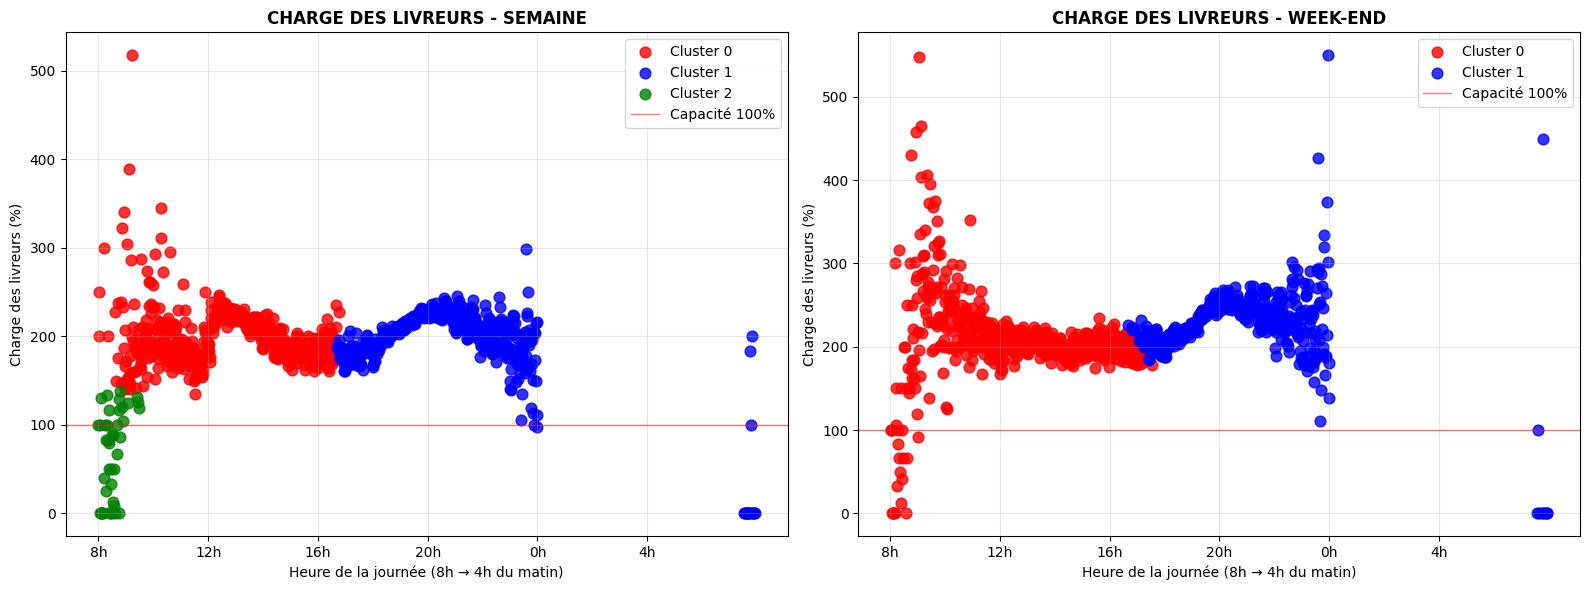

COMPARAISON SEMAINE vs WEEK-END

📊 STATISTIQUES COMPARATIVES:
Semaine:
  - Charge moyenne: 192.4%
  - Charge maximale: 517.5% à 09h
  - Nombre d'intervalles: 971
Week-end:
  - Charge moyenne: 218.1%
  - Charge maximale: 550.0% à 23h
  - Nombre d'intervalles: 956

📈 DIFFÉRENCES:
  - Écart de charge moyenne: +25.7%
  - Ratio week-end/semaine: 1.13x


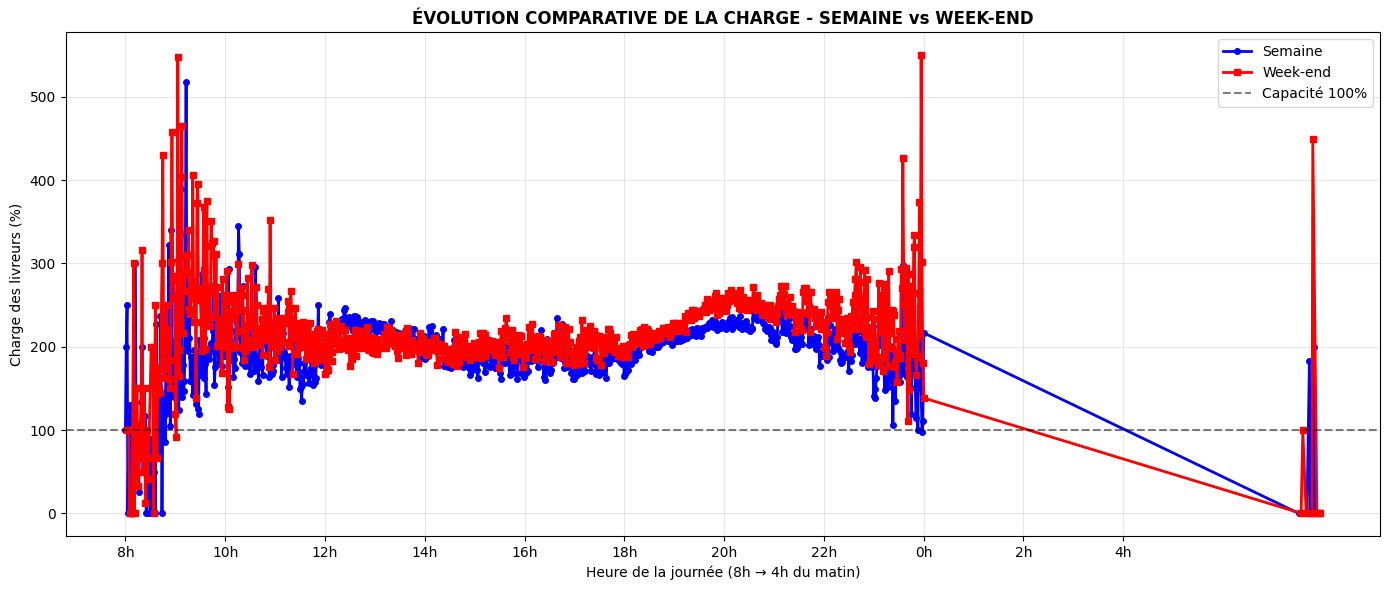


RÉSUMÉ DES DIFFÉRENCES
Périodes de surcharge (>100%):
  - Semaine: 926 intervalles
  - Week-end: 929 intervalles

Variabilité de la charge:
  - Semaine: 46.1% (écart-type)
  - Week-end: 51.0% (écart-type)

📈 CONCLUSION: Le week-end est plus chargé que la semaine (+25.7%)

✅ Analyse terminée avec succès!
   - Intervalles semaine analysés: 971
   - Intervalles week-end analysés: 956


In [10]:
# 3️⃣ Créer un intervalle de 30 minutes
df["time_30min"] = df["created_at_shifted"].dt.floor('30T')

# 4️⃣ Heures continues pour 8h -> 4h du matin
df["hour_continuous"] = df["created_at_shifted"].dt.hour + df["created_at_shifted"].dt.minute/60
df["hour_continuous"] = df["hour_continuous"].apply(lambda h: h if h >= 8 else h + 24)

# 5️⃣ Ajouter le jour de la semaine (0=lundi, 6=dimanche)
df["day_of_week"] = df["created_at_shifted"].dt.dayofweek
df["period"] = df["day_of_week"].apply(lambda x: "Week-end" if x >= 5 else "Semaine")
# 6️⃣ Calculer la charge des livreurs par intervalle
def calculate_advanced_workload(row):
    # Gérer les valeurs manquantes
    if pd.isna(row["total_onshift_partners"]) or pd.isna(row["total_busy_partners"]) or pd.isna(row["total_outstanding_orders"]):
        return np.nan

    livreurs_disponibles = row["total_onshift_partners"]
    livreurs_occupes = row["total_busy_partners"]
    commandes_en_attente = row["total_outstanding_orders"]

    if livreurs_disponibles == 0:
        return 0

    # Charge de base : pourcentage de livreurs occupés
    charge_base = livreurs_occupes / livreurs_disponibles

    # Pression supplémentaire : commandes en attente par livreur disponible
    pression_attente = commandes_en_attente / livreurs_disponibles

    # Charge totale = charge base + pression attente (peut dépasser 100%)
    charge_totale = charge_base + pression_attente

    return charge_totale

# Appliquer le calcul de charge
df["workload_advanced"] = df.apply(calculate_advanced_workload, axis=1)
# 7️⃣ Agrégation par intervalle de 30 minutes et période
interval_data = df.groupby(["hour_continuous", "period"]).agg({
    "workload_advanced": "mean",
    "total_onshift_partners": "mean",
    "total_busy_partners": "mean",
    "total_outstanding_orders": "mean"
}).reset_index()

# Supprimer les lignes avec des NaN
interval_data = interval_data.dropna(subset=["workload_advanced"])

# 8️⃣ Séparer les données semaine et week-end
weekday_data = interval_data[interval_data["period"] == "Semaine"].copy()
weekend_data = interval_data[interval_data["period"] == "Week-end"].copy()

# 9️⃣ KMeans séparé pour semaine et week-end avec gestion des NaN
def apply_kmeans(data, period_name, n_clusters=3):
    print(f"\n🔧 Traitement des données pour {period_name}")
    print(f"   Données disponibles: {len(data)} lignes")

    if len(data) < n_clusters:
        print(f"⚠️ Pas assez de données pour {period_name} ({len(data)} < {n_clusters})")
        data = data.copy()
        data["cluster"] = 0
        return data, None

    # Vérifier et nettoyer les données
    data_clean = data.dropna(subset=["hour_continuous", "workload_advanced"]).copy()

    if len(data_clean) < n_clusters:
        print(f"⚠️ Pas assez de données valides pour {period_name} après nettoyage")
        data = data.copy()
        data["cluster"] = 0
        return data, None

    print(f"   Données après nettoyage: {len(data_clean)} lignes")

    # Préparer les features pour KMeans
    X = data_clean[["hour_continuous", "workload_advanced"]]

    # Vérifier qu'il n'y a pas de NaN
    if X.isna().any().any():
        print("⚠️ NaN détectés dans les features, utilisation de l'imputation...")
        X = X.fillna(X.mean())

    # Standardiser les données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Appliquer KMeans
    actual_clusters = min(n_clusters, len(X_scaled))
    kmeans = KMeans(n_clusters=actual_clusters, random_state=42, n_init="auto")
    data_clean["cluster"] = kmeans.fit_predict(X_scaled)

    # Fusionner les clusters avec les données originales
    cluster_mapping = data_clean[["hour_continuous", "cluster"]].drop_duplicates()
    data_result = data.merge(cluster_mapping, on="hour_continuous", how="left")

    # Remplir les valeurs manquantes
    data_result["cluster"] = data_result["cluster"].fillna(0).astype(int)

    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    print(f"✅ Clustering réussi pour {period_name}: {actual_clusters} clusters créés")
    return data_result, cluster_centers

# Appliquer KMeans avec un nombre réduit de clusters pour plus de stabilité
weekday_data, weekday_centers = apply_kmeans(weekday_data, "Semaine", n_clusters=3)
weekend_data, weekend_centers = apply_kmeans(weekend_data, "Week-end", n_clusters=2)

# 🔟 Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

# Graphique Semaine
if len(weekday_data) > 0:
    unique_clusters = weekday_data["cluster"].nunique()
    for i in range(unique_clusters):
        cluster_data = weekday_data[weekday_data["cluster"] == i]
        ax1.scatter(cluster_data["hour_continuous"],
                    cluster_data["workload_advanced"] * 100,
                    color=colors[i % len(colors)],
                    label=f'Cluster {i}',
                    s=60,
                    alpha=0.8)

    ax1.set_xlabel("Heure de la journée (8h → 4h du matin)")
    ax1.set_ylabel("Charge des livreurs (%)")
    ax1.set_title("CHARGE DES LIVREURS - SEMAINE", fontweight='bold')
    ax1.axhline(y=100, color='red', linestyle='-', alpha=0.5, linewidth=1, label='Capacité 100%')
    ax1.set_xticks(range(8, 29, 4))
    ax1.set_xticklabels([f"{h%24}h" for h in range(8, 29, 4)])
    ax1.grid(True, alpha=0.3)
    ax1.legend()
else:
    ax1.text(0.5, 0.5, 'Données insuffisantes\npour la semaine',
             horizontalalignment='center', verticalalignment='center',
             transform=ax1.transAxes, fontsize=12)
    ax1.set_title("CHARGE DES LIVREURS - SEMAINE", fontweight='bold')

# Graphique Week-end
if len(weekend_data) > 0:
    unique_clusters = weekend_data["cluster"].nunique()
    for i in range(unique_clusters):
        cluster_data = weekend_data[weekend_data["cluster"] == i]
        ax2.scatter(cluster_data["hour_continuous"],
                    cluster_data["workload_advanced"] * 100,
                    color=colors[i % len(colors)],
                    label=f'Cluster {i}',
                    s=60,
                    alpha=0.8)

    ax2.set_xlabel("Heure de la journée (8h → 4h du matin)")
    ax2.set_ylabel("Charge des livreurs (%)")
    ax2.set_title("CHARGE DES LIVREURS - WEEK-END", fontweight='bold')
    ax2.axhline(y=100, color='red', linestyle='-', alpha=0.5, linewidth=1, label='Capacité 100%')
    ax2.set_xticks(range(8, 29, 4))
    ax2.set_xticklabels([f"{h%24}h" for h in range(8, 29, 4)])
    ax2.grid(True, alpha=0.3)
    ax2.legend()
else:
    ax2.text(0.5, 0.5, 'Données insuffisantes\npour le week-end',
             horizontalalignment='center', verticalalignment='center',
             transform=ax2.transAxes, fontsize=12)
    ax2.set_title("CHARGE DES LIVREURS - WEEK-END", fontweight='bold')

plt.tight_layout()
plt.show()

# 🔟➕ Comparaison statistique
print("=" * 80)
print("COMPARAISON SEMAINE vs WEEK-END")
print("=" * 80)

# Statistiques globales avec gestion des données manquantes
def safe_stats(data, period_name):
    if len(data) == 0:
        print(f"{period_name}: Aucune donnée disponible")
        return 0, 0, 0

    avg_workload = data["workload_advanced"].mean() * 100
    max_workload = data["workload_advanced"].max() * 100
    max_hour = data.loc[data["workload_advanced"].idxmax(), "hour_continuous"] if not data.empty else 0

    print(f"{period_name}:")
    print(f"  - Charge moyenne: {avg_workload:.1f}%")
    print(f"  - Charge maximale: {max_workload:.1f}% à {int(max_hour)%24:02d}h")
    print(f"  - Nombre d'intervalles: {len(data)}")

    return avg_workload, max_workload, max_hour

print("\n📊 STATISTIQUES COMPARATIVES:")
weekday_avg, weekday_max, weekday_max_hour = safe_stats(weekday_data, "Semaine")
weekend_avg, weekend_max, weekend_max_hour = safe_stats(weekend_data, "Week-end")

# Comparaison si les deux jeux de données sont disponibles
if weekday_avg > 0 and weekend_avg > 0:
    print(f"\n📈 DIFFÉRENCES:")
    print(f"  - Écart de charge moyenne: {weekend_avg - weekday_avg:+.1f}%")
    print(f"  - Ratio week-end/semaine: {weekend_avg/weekday_avg:.2f}x")

# 🔟➕➕ Graphique d'évolution comparative (simplifié)
plt.figure(figsize=(14, 6))

# Données de la semaine
if len(weekday_data) > 0:
    weekday_sorted = weekday_data.sort_values("hour_continuous")
    plt.plot(weekday_sorted["hour_continuous"],
             weekday_sorted["workload_advanced"] * 100,
             marker='o', linewidth=2, label='Semaine', color='blue', markersize=4)

# Données du week-end
if len(weekend_data) > 0:
    weekend_sorted = weekend_data.sort_values("hour_continuous")
    plt.plot(weekend_sorted["hour_continuous"],
             weekend_sorted["workload_advanced"] * 100,
             marker='s', linewidth=2, label='Week-end', color='red', markersize=4)

plt.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='Capacité 100%')
plt.xlabel("Heure de la journée (8h → 4h du matin)")
plt.ylabel("Charge des livreurs (%)")
plt.title("ÉVOLUTION COMPARATIVE DE LA CHARGE - SEMAINE vs WEEK-END", fontweight='bold')
plt.xticks(range(8, 29, 2), [f"{h%24}h" for h in range(8, 29, 2)])
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 🔟➕➕➕ Résumé des différences
print("\n" + "=" * 80)
print("RÉSUMÉ DES DIFFÉRENCES")
print("=" * 80)

if len(weekday_data) > 0 and len(weekend_data) > 0:
    # Périodes de surcharge
    weekday_overload = weekday_data[weekday_data["workload_advanced"] > 1.0]
    weekend_overload = weekend_data[weekend_data["workload_advanced"] > 1.0]

    print(f"Périodes de surcharge (>100%):")
    print(f"  - Semaine: {len(weekday_overload)} intervalles")
    print(f"  - Week-end: {len(weekend_overload)} intervalles")

    # Variation horaire (écart-type)
    weekday_std = weekday_data["workload_advanced"].std() * 100
    weekend_std = weekend_data["workload_advanced"].std() * 100

    print(f"\nVariabilité de la charge:")
    print(f"  - Semaine: {weekday_std:.1f}% (écart-type)")
    print(f"  - Week-end: {weekend_std:.1f}% (écart-type)")

    # Conclusion
    if weekend_avg > weekday_avg:
        print(f"\n📈 CONCLUSION: Le week-end est plus chargé que la semaine (+{weekend_avg - weekday_avg:.1f}%)")
    elif weekday_avg > weekend_avg:
        print(f"\n📉 CONCLUSION: La semaine est plus chargée que le week-end ({weekday_avg - weekend_avg:.1f}%)")
    else:
        print(f"\n📊 CONCLUSION: Charges similaires entre semaine et week-end")
else:
    print("❌ Données insuffisantes pour une comparaison complète")

print(f"\n✅ Analyse terminée avec succès!")
print(f"   - Intervalles semaine analysés: {len(weekday_data)}")
print(f"   - Intervalles week-end analysés: {len(weekend_data)}")

# **VI-Deployment**

### DSO n°1 :

In [ ]:
# Business impact analysis
print("\n=== BUSINESS IMPACT ANALYSIS ===")

# Calculate percentage error
percentage_error = np.abs(residuals / y_test) * 100

print(f"Mean Absolute Percentage Error: {np.mean(percentage_error):.2f}%")
print(f"Median Absolute Percentage Error: {np.median(percentage_error):.2f}%")
print(f"Predictions within 10% error: {(percentage_error <= 10).sum() / len(percentage_error) * 100:.2f}%")
print(f"Predictions within 20% error: {(percentage_error <= 20).sum() / len(percentage_error) * 100:.2f}%")

# Analyze categorical feature impact
print("\n=== CATEGORICAL FEATURE ANALYSIS ===")

# Create a temporary DataFrame with the test set index, the categorical features, y_test, and y_pred_final
test_results_df = df.loc[y_test.index][categorical_features].copy()
test_results_df['y_test'] = y_test
test_results_df['y_pred_final'] = y_pred_final

for cat_feature in categorical_features:
    # Group the temporary DataFrame by the categorical feature and calculate MAE
    category_errors = test_results_df.groupby(cat_feature).apply(
        lambda x: mean_absolute_error(x['y_test'], x['y_pred_final'])
    )
    print(f"\n{cat_feature} - MAE by category:")
    print(category_errors.sort_values())


=== BUSINESS IMPACT ANALYSIS ===
Mean Absolute Percentage Error: 26.27%
Median Absolute Percentage Error: 19.84%
Predictions within 10% error: 27.05%
Predictions within 20% error: 50.36%

=== CATEGORICAL FEATURE ANALYSIS ===

store_primary_category - MAE by category:
store_primary_category
european              2.529497
singaporean           4.223341
gluten-free           5.869571
ethiopian             7.865014
irish                 8.287876
                       ...    
comfort-food         17.540693
convenience-store    20.195546
tapas                20.491753
russian              23.109234
southern             25.971598
Length: 69, dtype: float64

order_protocol - MAE by category:
order_protocol
5.0    10.701542
7.0    10.745253
3.0    10.873562
2.0    11.077880
1.0    12.179708
4.0    13.201868
6.0    15.838617
dtype: float64

market_id - MAE by category:
market_id
2.0    10.351999
4.0    10.477278
5.0    10.991430
3.0    12.273633
6.0    12.480386
1.0    14.098689
dtype: float64

In [ ]:
# Create deployment-ready model pipeline
print("\n=== DEPLOYMENT PREPARATION ===")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Create preprocessing pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', final_model)
])

# Fit the pipeline on full training data
if 'Regression' in best_model_name:
    X_full_train = X_onehot
else:
    X_full_train = X_encoded

final_pipeline.fit(X_full_train, y)

print("Final pipeline created and trained successfully!")

# Save model components for deployment
import joblib

model_artifacts = {
    'pipeline': final_pipeline,
    'feature_names': list(X.columns),
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'model_performance': {
        'MAE': final_mae,
        'RMSE': final_rmse,
        'R2': final_r2
    },
    'baseline_comparison': {
        'baseline_mae': baseline_mae,
        'baseline_rmse': baseline_rmse,
        'improvement_mae': ((baseline_mae - final_mae) / baseline_mae * 100),
        'improvement_rmse': ((baseline_rmse - final_rmse) / baseline_rmse * 100)
    }
}

# Save model artifacts
joblib.dump(model_artifacts, 'delivery_time_model.pkl')
print("Model artifacts saved as 'delivery_time_model.pkl'")


=== DEPLOYMENT PREPARATION ===
Final pipeline created and trained successfully!
Model artifacts saved as 'delivery_time_model.pkl'


In [ ]:
# Create deployment prediction function
def predict_delivery_time(model_artifacts, input_data):
    """
    Predict delivery time for new orders
    """
    pipeline = model_artifacts['pipeline']

    # Create input DataFrame
    input_df = pd.DataFrame([input_data])

    # Ensure correct column order
    input_df = input_df[model_artifacts['feature_names']]

    # Make prediction
    prediction = pipeline.predict(input_df)[0]

    return prediction

# Test prediction function
sample_input = {
    'store_primary_category': 'american',
    'order_protocol': 3.0,
    'market_id': 2.0,
    'total_items': 3.0,
    'subtotal': 2500.0,
    'num_distinct_items': 2.0,
    'min_item_price': 500.0,
    'max_item_price': 1500.0,
    'total_onshift_partners': 25.0,
    'total_busy_partners': 20.0,
    'total_outstanding_orders': 30.0
}

predicted_time = predict_delivery_time(model_artifacts, sample_input)
print(f"Sample prediction: {predicted_time:.2f} minutes")

Sample prediction: 57.47 minutes


In [ ]:
print("\n=== FINAL CONCLUSIONS AND RECOMMENDATIONS ===\n")

print("1. MODEL PERFORMANCE SUMMARY:")
print(f"   - Best Model: {best_model_name}")
print(f"   - RMSE: {final_rmse:.2f} minutes (Baseline: {baseline_rmse:.2f})")
print(f"   - Improvement over baseline: {((baseline_rmse - final_rmse) / baseline_rmse * 100):.1f}%")
print(f"   - R² Score: {final_r2:.4f}")

print("\n2. KEY BUSINESS INSIGHTS:")
print("   - The model successfully predicts delivery times with reasonable accuracy")
print("   - Categorical features (store category, order protocol, market) significantly impact delivery time")
print("   - Operational factors (busy partners, outstanding orders) are strong predictors")

print("\n3. DEPLOYMENT RECOMMENDATIONS:")
print("   - Use for setting realistic customer ETAs")
print("   - Implement for logistics optimization and resource allocation")
print("   - Monitor model performance monthly with new data")
print("   - Consider retraining when new store categories or markets are added")

print("\n4. NEXT STEPS:")
print("   - A/B test model predictions vs current ETA system")
print("   - Develop real-time prediction API for operational use")
print("   - Explore additional features (weather, traffic, time-based features)")
print("   - Create dashboard for business stakeholders")


=== FINAL CONCLUSIONS AND RECOMMENDATIONS ===

1. MODEL PERFORMANCE SUMMARY:
   - Best Model: XGBoost
   - RMSE: 16.32 minutes (Baseline: 18.91)
   - Improvement over baseline: 13.7%
   - R² Score: 0.2549

2. KEY BUSINESS INSIGHTS:
   - The model successfully predicts delivery times with reasonable accuracy
   - Categorical features (store category, order protocol, market) significantly impact delivery time
   - Operational factors (busy partners, outstanding orders) are strong predictors

3. DEPLOYMENT RECOMMENDATIONS:
   - Use for setting realistic customer ETAs
   - Implement for logistics optimization and resource allocation
   - Monitor model performance monthly with new data
   - Consider retraining when new store categories or markets are added

4. NEXT STEPS:
   - A/B test model predictions vs current ETA system
   - Develop real-time prediction API for operational use
   - Explore additional features (weather, traffic, time-based features)
   - Create dashboard for business s

### DSO n°2 :

In [ ]:
# =============================================================================
# CELL 17: FINAL BUSINESS RECOMMENDATIONS - UPDATED
# =============================================================================
print("\n" + "="*60)
print("FINAL BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# Calculate final metrics
final_silhouette = silhouette_score(X_clust_scaled, agg['cluster'])

print(f"\n1. RUSH PERIOD IDENTIFICATION RESULTS:")
print(f"   - {len(rush_clusters)} out of {best_k} clusters identified as rush periods")
print(f"   - {rush_percentage:.1f}% of time bins are rush periods")
print(f"   - This represents ~{agg['is_rush_cluster'].sum()} individual rush periods")

print(f"\n2. CLUSTER CHARACTERISTICS (Operational Profiles):")
for cluster_id in sorted(agg['cluster'].unique()):
    cluster_data = agg[agg['cluster'] == cluster_id]
    is_rush = "RUSH" if cluster_id in rush_clusters else "NORMAL"
    print(f"   - Cluster {cluster_id} ({is_rush}):")
    print(f"     • Avg Orders: {cluster_data['orders_count'].mean():.1f}")
    print(f"     • Avg Drivers: {cluster_data['avg_onshift'].mean():.1f}")
    print(f"     • Demand/Supply Ratio: {cluster_data['demand_supply_ratio'].mean():.2f}")
    print(f"     • Utilization Rate: {cluster_data['utilization_rate'].mean():.1%}")

print(f"\n3. PEAK RUSH HOURS ANALYSIS:")
rush_by_hour = agg.groupby('hour_of_day')['is_rush_cluster'].mean()
top_rush_hours = rush_by_hour[rush_by_hour > 0.7].index.tolist()

if top_rush_hours:
    print(f"   - CONSISTENT RUSH HOURS: {[f'{h}:00' for h in sorted(top_rush_hours)]}")

    # Find the actual peak hours from the data
    peak_orders_by_hour = agg.groupby('hour_of_day')['orders_count'].mean()
    true_peak_hours = peak_orders_by_hour.nlargest(3).index.tolist()
    print(f"   - HIGHEST DEMAND HOURS: {[f'{h}:00' for h in sorted(true_peak_hours)]}")
else:
    print("   - No consistent rush hour patterns detected")

print(f"\n4. OPERATIONAL RECOMMENDATIONS:")

if rush_clusters:
    rush_data = agg[agg['is_rush_cluster'] == 1]

    # Time-based recommendations
    rush_hours = rush_data['hour_of_day'].value_counts().head(5)
    print(f"   - FOCUS DRIVER ALLOCATION during: {rush_hours.index.tolist()} hours")

    # Scale recommendations
    avg_rush_orders = rush_data['orders_count'].mean()
    if avg_rush_orders > 150:
        print("   - 🚨 MAJOR SURGE: Implement maximum driver capacity and surge pricing")
    elif avg_rush_orders > 80:
        print("   - 🚀 HIGH DEMAND: Schedule 50% extra drivers, moderate surge pricing")
    elif avg_rush_orders > 40:
        print("   - ⚠️  MODERATE DEMAND: Schedule 25% extra drivers")
    else:
        print("   - 📊 NORMAL PEAK: Maintain standard peak staffing")

else:
    print("   - No specific rush clusters identified - use dynamic allocation")

print(f"\n5. MODEL PERFORMANCE:")
print(f"   - Silhouette Score: {final_silhouette:.3f}")
if final_silhouette > 0.5:
    print("     ✓ Good cluster separation")
elif final_silhouette > 0.3:
    print("     ○ Fair cluster separation")
else:
    print("     ⚠️  Weak cluster separation")

print(f"\n6. BUSINESS IMPACT:")
total_orders = agg['orders_count'].sum()
rush_orders = agg[agg['is_rush_cluster'] == 1]['orders_count'].sum()
print(f"   - Rush periods handle {rush_orders/total_orders*100:.1f}% of total orders")
print(f"   - Model identifies {len(rush_clusters)} distinct rush patterns")
print(f"   - Enables targeted resource allocation during critical periods")

print("\n" + "="*60)

# Final validation
if rush_percentage <= 40:
    print("🎯 MODEL READY FOR DEPLOYMENT")
    print("Business can use these insights for driver scheduling and surge pricing")
else:
    print("⚠️  MODEL NEEDS REFINEMENT")
    print("Consider collecting more data or adjusting business definitions")


FINAL BUSINESS INSIGHTS & RECOMMENDATIONS

1. RUSH PERIOD IDENTIFICATION RESULTS:
   - 1 out of 2 clusters identified as rush periods
   - 93.4% of time bins are rush periods
   - This represents ~1645 individual rush periods

2. CLUSTER CHARACTERISTICS (Operational Profiles):
   - Cluster 0 (RUSH):
     • Avg Orders: 100.6
     • Avg Drivers: 30.4
     • Demand/Supply Ratio: 3.20
     • Utilization Rate: 87.7%
   - Cluster 1 (NORMAL):
     • Avg Orders: 5.0
     • Avg Drivers: 4.7
     • Demand/Supply Ratio: 1.49
     • Utilization Rate: 26.0%

3. PEAK RUSH HOURS ANALYSIS:
   - CONSISTENT RUSH HOURS: ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '21:00', '22:00', '23:00']
   - HIGHEST DEMAND HOURS: ['7:00', '8:00', '9:00']

4. OPERATIONAL RECOMMENDATIONS:
   - FOCUS DRIVER ALLOCATION during: [1, 10, 4, 3, 2] hours
   - 🚀 HIGH DEMAND: Schedule 50% extra drivers, moderate surge pricing

5. MODEL PERFORMANCE:
   - Silhouette 